In [1]:

import argparse
import json
import logging
import math
import os
import random
from pathlib import Path
import sys
import evaluate
metric = evaluate.load("rouge")
from scipy import stats
from datasets import concatenate_datasets

import datasets
import evaluate
import nltk
import numpy as np
import pandas as pd
from torch import nn
import torch
from accelerate import Accelerator
from accelerate import DistributedDataParallelKwargs
from accelerate.utils import DummyOptim, DummyScheduler
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from datasets import load_dataset
from filelock import FileLock
from huggingface_hub import Repository, create_repo
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from copy import deepcopy
from torch.nn import CrossEntropyLoss
import gc
from accelerate import FullyShardedDataParallelPlugin
from peft import LoraConfig, PeftConfig, PeftModel, get_peft_model, prepare_model_for_int8_training,  TaskType
from torch.distributed.fsdp import FullyShardedDataParallel as FSDP, StateDictType, FullStateDictConfig
from peft.utils.other import fsdp_auto_wrap_policy
from datasets import Dataset
from datasets import concatenate_datasets
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import transformers
from transformers import (
    CONFIG_MAPPING,
    MODEL_MAPPING,
    AutoConfig,
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    DataCollatorForSeq2Seq,
    SchedulerType,
    get_scheduler,
    AutoModelForCausalLM,
)
pd.options.display.float_format = '{:,.2f}'.format
from transformers import pipeline
from transformers.pipelines.pt_utils import KeyDataset
from datasets import Dataset, load_from_disk
pd.set_option('max_colwidth', 800)
pd.set_option('display.max_columns', 100)

def plot_heatmap(df, figsize=(6, 5), fmt='.2f',):
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(240, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(df, cmap=cmap, vmax=1.0, vmin=-1.0, cbar_kws={"shrink": .8}, center=0,
                square=True, linewidths=.5, annot=True, fmt=fmt)
    plt.title("Column Correlation Heatmap")
    plt.show()
    

def plot_correlation_heatmap(df, threshold=0, figsize=(6, 5), fmt='.2f', spearman=False):
    import seaborn as sns
    corr = df.corr()
    if spearman:
        from scipy import stats
        res = stats.spearmanr(df.values)
        corr = pd.DataFrame(res.statistic, index=corr.index, columns=corr.columns)

    # corr = corr.where(np.abs(corr) > threshold, 0)

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(240, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=-1.0, cbar_kws={"shrink": .8}, center=0,
                square=True, linewidths=.5, annot=True, fmt=fmt)
    plt.title("Column Correlation Heatmap")
    plt.show()
    
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.title("Columns as heatmap plot")
    sns.heatmap(df, cmap='coolwarm', ax=ax)
    plt.show()
    
    return corr

def calculate_jsd(x, y):
    if not torch.is_tensor(x):
        x = torch.tensor(x)
    if not torch.is_tensor(y):
        y = torch.tensor(y)
    jsd_m = 0.5 * (x + y)
    jsd = 0.5 * nn.KLDivLoss(reduction='none', log_target=False)(torch.log(x), jsd_m) + 0.5 * nn.KLDivLoss(reduction='none', log_target=False)(torch.log(y), jsd_m)
    jsd = jsd.sum(-1).tolist()
    return jsd
    

/home/ahemf/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
model_name="t5-large"
dataset_name="samsum"
N_FOLD=2

max_target_length=128
padding="max_length"
proba_columns = ["baseline_lora", "inverted_jsd", "proba_v10_cumulative_windowed", "proba_v11_cumulative_windowed", "proba_v12_cumulative_windowed",]


# seed = 42
# total_fractions = 2
# our_fraction = 0
# train_dataset = train_dataset.shuffle(seed).flatten_indices()
# fraction_size = len(train_dataset)//total_fractions + 1
# train_dataset = train_dataset.select(range(our_fraction * fraction_size, min((our_fraction+1) * fraction_size, len(train_dataset) - 1)))

In [3]:
models = dict()
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
dataset = load_dataset(dataset_name)
models["pretrained"] = model
generator=pipeline(task='text2text-generation',model=model,tokenizer=tokenizer, max_length=max_target_length)
# generator._forward_params
# generator("summarize: A: Hi Tom, are you busy tomorrow’s afternoon?\r\nB: I’m pretty sure I am. What’s up?\r\nA: Can you go with me to the animal shelter?.\r\nB: What do you want to do?\r\nA: I want to get a puppy for my son.\r\nB: That will make him so happy.\r\nA: Yeah, we’ve discussed it many times. I think he’s ready now.\r\nB: That’s good. Raising a dog is a tough issue. Like having a baby ;-) \r\nA: I'll get him one of those little dogs.\r\nB: One that won't grow up too big;-)\r\nA: And eat too much;-))\r\nB: Do you know which one he would like?\r\nA: Oh, yes, I took him there last Monday. He showed me one that he really liked.\r\nB: I bet you had to drag him away.\r\nA: He wanted to take it home right away ;-).\r\nB: I wonder what he'll name it.\r\nA: He said he’d name it after his dead hamster – Lemmy  - he's  a great Motorhead fan :-)))",
#           max_length=10, num_return_sequences=4, num_beams=4, do_sample=True)


/home/ahemf/anaconda3/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
Found cached dataset samsum (/home/ahemf/.cache/huggingface/datasets/samsum/samsum/0.0.0/f1d7c6b7353e6de335d444e424dc002ef70d1277109031327bc9cc6af5d3d46e)
100%|██████████| 3/3 [00:00<00:00, 740.13it/s]


In [10]:
from peft import LoraConfig, PeftConfig, PeftModel, get_peft_model
for proba_col in proba_columns: 
    
    md = deepcopy(model)
    if "_lora" not in proba_col:
        state_dict = torch.load(f"outputs/{model_name}/{dataset_name}/folds_{N_FOLD}_{proba_col}_combined/model.pt", map_location='cpu')
        md.load_state_dict(state_dict)
    else:
        
        peft_config = PeftConfig.from_pretrained(f"outputs/{model_name}/{dataset_name}/{proba_col}")
        md = PeftModel.from_pretrained(md, f"outputs/{model_name}/{dataset_name}/{proba_col}")
    md = md.eval()
    models[proba_col] = md
    
    

<All keys matched successfully>

<All keys matched successfully>

<All keys matched successfully>

<All keys matched successfully>

In [9]:
!ls outputs/t5-large/samsum/folds_2_proba_v10_cumulative_windowed_combined

folds_2_proba_v10_cumulative_windowed_combined	pytorch_model.bin


In [69]:
# https://github.com/huggingface/transformers/blob/v4.28.1/src/transformers/pipelines/text2text_generation.py


In [84]:
dsets = []

for FOLD in range(N_FOLD):
    ds = Dataset.load_from_disk(f"outputs/{model_name}/{dataset_name}/fold_{N_FOLD}_{FOLD}")
    ds = ds.rename_column("proba", f"proba{FOLD}")
    md = deepcopy(model)
    md.load_state_dict(torch.load(f"outputs/{model_name}/{dataset_name}/fold_{N_FOLD}_{FOLD}/model.pt", map_location = 'cpu'))
    md = md.eval()
    models[FOLD] = md
    
    dsets.append(ds)
    
combined_ds = Dataset.load_from_disk(f"outputs/{model_name}/{dataset_name}/folds_{N_FOLD}_combined")
combined_ds_jsd = Dataset.load_from_disk(f"outputs/{model_name}/{dataset_name}/folds_{N_FOLD}_jsd")
combined_ds_jsd = combined_ds_jsd.map(lambda x:{k: v + [v[-1]]*2 for k, v in x.items()})
combined_ds_jsd = combined_ds_jsd.rename_column("proba0", "proba0_jsd").rename_column("proba1", "proba1_jsd")
combined_ds = concatenate_datasets([combined_ds, combined_ds_jsd], axis=1)

md = deepcopy(model)
md.load_state_dict(torch.load(f"outputs/{model_name}/{dataset_name}/baseline/model.pt", map_location = 'cpu'))
models["baseline"] = md


<All keys matched successfully>

<All keys matched successfully>

<All keys matched successfully>

In [100]:
[(i, sum(np.isnan(v))) for i, v in enumerate(combined_ds["proba_v9_cumulative_windowed"]) if sum(np.isnan(v))>0][:10]
combined_ds[3]["proba_v9_cumulative_windowed"]

[(3, 3),
 (6, 4),
 (9, 10),
 (14, 4),
 (26, 3),
 (28, 3),
 (47, 3),
 (49, 3),
 (64, 3),
 (68, 3)]

[0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 nan,
 nan,
 nan,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01]

In [71]:
combined_ds.save_to_disk(f"outputs/{model_name}/{dataset_name}/folds_{N_FOLD}_combined")

In [96]:
gen_kwargs = {
                "max_length": max_target_length,
                "num_beams": 1,
    }


def investigate(idx, input_text, label_text, models, generator, tokenizer, gen_kwargs, padding, **more_gen_kwargs):
    gen_kwargs = deepcopy(gen_kwargs)
    gen_kwargs.update(more_gen_kwargs)
    labels = tokenizer(text_target=[label_text], max_length=gen_kwargs["max_length"], padding=padding, truncation=True)
    label_ids = labels["input_ids"][0]
    labels = [tokenizer.decode(i) for i in label_ids]
    pipeline_generation = generator(input_text, **gen_kwargs)
    pipeline_token_ids = tokenizer(text_target=[pipeline_generation[0]['generated_text']], max_length=gen_kwargs["max_length"], padding=padding, truncation=True)
    pipeline_token_ids = pipeline_token_ids["input_ids"][0]
    pipeline_decoded = [tokenizer.decode(i) for i in pipeline_token_ids]
    model_texts = dict()
    model_texts["input"] = input_text
    model_texts["label"] = label_text
    model_texts["pipeline"] = pipeline_generation[0]['generated_text']

    
    batch = tokenizer(input_text, max_length=gen_kwargs["max_length"], padding=padding, truncation=True, return_tensors="pt")
    model_predictions = dict()

    for FOLD, used_model in models.items():
        with torch.no_grad():
            generated_ids = used_model.generate(
                            input_ids=batch["input_ids"],
                            attention_mask=batch["attention_mask"],
                            **gen_kwargs,
                        )
        generated_ids = generated_ids.squeeze().tolist()
        if generated_ids[0] == tokenizer.pad_token_id:
            generated_ids = generated_ids[1:]
        if len(generated_ids) < gen_kwargs["max_length"]:
            generated_ids = generated_ids + [tokenizer.pad_token_id]*(gen_kwargs["max_length"] - len(generated_ids))
        generated_ids_decoded = [tokenizer.decode(i) for i in generated_ids]
        model_predictions[f"generated_token_ids_{FOLD}"] = generated_ids
        model_predictions[f"generated_tokens_{FOLD}"] = generated_ids_decoded
        model_texts[FOLD] = tokenizer.decode(generated_ids, skip_special_tokens=True)

    rouge_scores = dict()
    for FOLD, predictions in model_texts.items():
        rouge_score = metric.compute(predictions=[predictions], references=[label_text], use_stemmer=True)
        rouge_score["text"] = predictions
        rouge_scores[FOLD] = rouge_score
    rouge_df = pd.DataFrame(rouge_scores.values(), index=rouge_scores.keys())
    rouge_df


    probas_dict = combined_ds[idx]
    our_dict = {"label_ids": label_ids, "labels": labels, 
                        "pipeline_token_ids": pipeline_token_ids, "pipeline_tokens": pipeline_decoded, **model_predictions}

    probas_dict.update(our_dict)
    # print({k: len(v) for k, v in probas_dict.items()})
    df = pd.DataFrame(probas_dict)
    # df = df.loc[((df==tokenizer.pad_token).sum(axis=1) < 6)|(df["label_ids"]!=tokenizer.pad_token_id)]
    return rouge_df, df


In [97]:
idx = 3
label_text = dataset["train"][idx]["summary"]
input_text = f'summarize: {dataset["train"][idx]["dialogue"]}'
rouge_df, df = investigate(idx, input_text, label_text, models, generator, tokenizer, gen_kwargs, padding, do_sample=True, num_beams=1, temperature=1.0)

rouge_df
df

,rouge1,rouge2,rougeL,rougeLsum,text
input,0.46,0.09,0.42,0.37,"summarize: Edward: Rachel, I think I'm in ove with Bella..\r\nrachel: Dont say anything else..\r\nEdward: What do you mean??\r\nrachel: Open your fu**ing door.. I'm outside"
label,1.00,1.00,1.00,1.00,Edward thinks he is in love with Bella. Rachel wants Edward to open his door. Rachel is outside.
pipeline,0.26,0.07,0.19,0.19,rachel is upset after we're told to run away... rachel: lets run ..
pretrained,0.12,0.00,0.12,0.12,the two of them were on the phone before the kiss. rachel: 'ooo... the door!'
proba_v3,0.59,0.38,0.59,0.59,Edward thinks he's in love with Bella. Rachel doesn't want to talk to him.
proba_v4_10_epoch,0.52,0.40,0.52,0.52,Edward is in love with Bella. Rachel knows it.
proba_v4_8_epoch,0.65,0.41,0.65,0.65,Edward is in love with Bella. Rachel tells him to open the door.
proba_v7,0.69,0.47,0.44,0.44,Edward is thinking about Bella. Rachel is outside. Edward is in love with Bella.
proba_v8,0.69,0.59,0.69,0.69,Edward thinks he's in love with Bella. Rachel is outside.
proba_tv_approx_cumulative_windowed,0.68,0.41,0.59,0.59,"Edward finds Bella attractive, he is in love with her. Rachel is inside the house and she wants Edward to open the door."


,proba0,proba1,proba_v1,proba_v2,proba_v3,proba_v4,proba_v5,proba_v6,proba_v7,proba_v8,proba_v4_cumulative,proba_v7_cumulative,proba_tv_approx_cumulative,proba_v4_cumulative_windowed,proba_v7_cumulative_windowed,proba_tv_approx_cumulative_windowed,proba_v4_cumulative_w2,proba_v7_cumulative_w2,proba_tv_approx_cumulative_w2,proba_v4_cumulative_windowed_w2,proba_v7_cumulative_windowed_w2,proba_tv_approx_cumulative_windowed_w2,proba_v9_cumulative_windowed_w2,proba_v9_cumulative_windowed,proba_v9_cumulative_w2,proba_v9_cumulative,proba0_jsd,proba1_jsd,jsd,inverse_jsd,inverted_jsd,label_ids,labels,pipeline_token_ids,pipeline_tokens,generated_token_ids_pretrained,generated_tokens_pretrained,generated_token_ids_proba_v3,generated_tokens_proba_v3,generated_token_ids_proba_v4_10_epoch,generated_tokens_proba_v4_10_epoch,generated_token_ids_proba_v4_8_epoch,generated_tokens_proba_v4_8_epoch,generated_token_ids_proba_v7,generated_tokens_proba_v7,generated_token_ids_proba_v8,generated_tokens_proba_v8,generated_token_ids_proba_tv_approx_cumulative_windowed,generated_tokens_proba_tv_approx_cumulative_windowed,generated_token_ids_inverted_jsd,generated_tokens_inverted_jsd,generated_token_ids_0,generated_tokens_0,generated_token_ids_1,generated_tokens_1,generated_token_ids_baseline,generated_tokens_baseline
0,0.81,0.34,0.53,0.27,0.18,0.15,0.28,0.16,0.30,0.08,0.15,0.30,0.76,0.20,0.28,0.87,0.15,0.30,0.76,0.18,0.28,0.84,0.01,0.01,0.01,0.01,0.79,0.35,0.12,0.17,0.98,8200,Edward,3,,8,the,8200,Edward,8200,Edward,8200,Edward,8200,Edward,8200,Edward,8200,Edward,15868,Rachel,8200,Edward,8200,Edward,8200,Edward
1,0.48,0.70,0.78,0.34,0.37,0.35,0.45,0.36,0.46,0.20,0.22,0.27,0.93,0.26,0.33,0.91,0.22,0.27,0.93,0.22,0.27,0.93,0.01,0.01,0.01,0.01,0.48,0.34,0.06,0.28,0.99,317,think,52,r,192,two,317,think,19,is,19,is,19,is,317,think,12902,finds,19,is,317,think,317,think,19,is
2,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.22,0.27,0.93,0.50,0.56,0.93,0.22,0.27,0.93,0.28,0.35,0.91,0.01,0.01,0.01,0.01,0.35,0.60,0.37,0.06,0.93,7,s,9,a,13,of,7,s,16,in,16,in,1631,thinking,7,s,5377,Bell,1067,outside,7,s,7,s,16,in
3,0.96,0.98,0.98,0.95,0.95,0.94,0.96,0.94,0.96,0.91,0.33,0.44,0.88,0.51,0.55,0.96,0.33,0.44,0.88,0.64,0.70,0.94,0.01,0.01,0.01,0.01,0.91,0.93,0.02,0.57,1.00,3,,8738,chel,135,them,3,,333,love,333,love,81,about,3,,9,a,3558,asking,3,,3,,333,love
4,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.94,0.96,0.99,0.49,0.49,0.99,0.94,0.96,0.99,0.60,0.61,0.99,0.01,0.01,0.01,0.01,0.95,1.00,0.20,0.11,0.96,88,he,19,is,130,were,88,he,28,with,28,with,5377,Bell,88,he,5250,attractive,8200,Edward,88,he,88,he,28,with
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.01,0.01,0.01,0.01,0.00,0.00,0.03,0.49,0.99,0,<pad>,0,<pad>,0,<pad>,0,<pad>,0,<pad>,0,<pad>,0,<pad>,0,<pad>,0,<pad>,0,<pad>,0,<pad>,0,<pad>,0,<pad>
124,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.01,0.01,0.01,0.01,0.00,0.00,0.04,0.41,0.99,0,<pad>,0,<pad>,0,<pad>,0,<pad>,0,<pad>,0,<pad>,0,<pad>,0,<pad>,0,<pad>,0,<pad>,0,<pad>,0,<pad>,0,<pad>
125,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.01,0.01,0.01,0.01,0.00,0.00,0.05,0.34,0.99,0,<pad>,0,<pad>,0,<pad>,0,<pad>,0,<pad>,0,<pad>,0,<pad>,0,<pad>,0,<pad>,0,<pad>,0,<pad>,0,<pad>,0,<pad>
126,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.01,0.01,0.01,0.01,0.00,0.00,0.05,0.34,0.99,0,<pad>,0,<pad>,0,<pad>,0,<pad>,0,<pad>,0,<pad>,0,<pad>,0,<pad>,0,<pad>,0,<pad>,0,<pad>,0,<pad>,0,<pad>


In [117]:
def cumulative_product_window(array, window):
    array = np.array(array)
    # Create an array with the same size as the input array
    result = np.empty_like(array)

    # Pad the input array with ones to the left
    padded_array = np.pad(array, (window - 1, 0), mode='constant', constant_values=(1,))

    # Calculate the cumulative product within the given window length
    for i in range(len(array)):
        result[i] = np.prod(padded_array[i:i + window])

    return result

def windowed_applicator(array, window):
    array = np.array(array)
    result = np.empty_like(array)
    
    padded_array = np.pad(array, (0, window - 1), mode='edge')
    for i in range(len(array)):
        result[i] = np.mean(padded_array[i:i +window])
    return result # / np.mean(result)


def fit_in_zero_one_range_min_max(initial_array):
    initial_array = np.array(initial_array)

    # Normalize the initial array
    min_value = initial_array.min()
    range_value = initial_array.max() - min_value
    normalized_array = (initial_array - min_value) / range_value

    # Scale the normalized array to the desired range (0.01 to 1)
    min_mapped_value = 0.01
    max_mapped_value = 1
    mapped_array = normalized_array * (max_mapped_value - min_mapped_value) + min_mapped_value
    return mapped_array

window = 3
probas_cumulative = list(zip(cumulative_product_window(df["proba0"], window), cumulative_product_window(df["proba1"], window)))
intermediate = [np.min(d) for d in probas_cumulative]
# proba_v9_cumulative = [np.abs(1/np.log10(d)) for d in intermediate]
proba_v9_sqrt = [np.sqrt(d) for d in intermediate]
proba_v9_exp = [np.exp(d) - 0.9999 for d in intermediate]

proba_v9_cumulative_windowed = windowed_applicator(proba_v9_sqrt, window)
proba_v9_cumulative_windowed_zero2one=fit_in_zero_one_range_min_max(proba_v9_cumulative_windowed)

pd.set_option('display.max_rows', 200)
pd.options.display.float_format = '{:,.4f}'.format
pd.DataFrame(list(zip(proba_v9_cumulative_windowed,proba_v9_cumulative_windowed_zero2one, proba_v9_exp, proba_v9_sqrt, intermediate)), 
            columns=["windowed","zero2one", "exp","sqrt","min_only"])


,windowed,zero2one,exp,sqrt,min_only
0,0.5187,0.5249,0.4021,0.5813,0.3379
1,0.5514,0.5574,0.2683,0.4874,0.2376
2,0.7164,0.7211,0.2683,0.4874,0.2376
3,0.7233,0.7279,0.5869,0.6795,0.4617
4,0.6682,0.6733,1.6245,0.9823,0.9648
5,0.5122,0.5184,0.2947,0.5081,0.2582
6,0.6742,0.6792,0.3028,0.5142,0.2644
7,0.8355,0.8393,0.3028,0.5142,0.2644
8,0.9974,1.0000,1.6867,0.9941,0.9883
9,0.9679,0.9707,1.7078,0.9980,0.9961


In [98]:
nSeq=30
np.prod(df["proba0"].head(nSeq))
np.prod(df["proba1"].head(nSeq))

def cumulative_product_window(array, window):
    # Create an array with the same size as the input array
    result = np.empty_like(array)

    # Pad the input array with ones to the left
    padded_array = np.pad(array, (window - 1, 0), mode='constant', constant_values=(1,))

    # Calculate the cumulative product within the given window length
    for i in range(len(array)):
        result[i] = np.prod(padded_array[i:i + window])

    return result
check_df = df[["proba0", "proba1"]].head(nSeq)

def min_together(arr1, arr2, window):
    arr1_cp = cumulative_product_window(arr1, window)
    arr2_cp = cumulative_product_window(arr2, window)
    
    min_cp = np.minimum(arr1_cp, arr2_cp)
    # min_cp = np.sqrt(arr1_cp * arr2_cp) *  min_cp**1
    return min_cp


def windowed_minculator(arr1, arr2, window):
    min_cp = min_together(arr1, arr2, window)
    result = np.empty_like(min_cp)
    
    padded_array = np.pad(min_cp, (0, window - 1), mode='edge')
    for i in range(len(min_cp)):
        result[i] = np.mean(padded_array[i:i +window])
    return result # / np.mean(result)
    

# window = 1
# check_df[f"windowed_min_{window}"] = min_together(check_df["proba0"].values, check_df["proba1"].values, window)
# check_df[f"windowed_min_weights_{window}"] = windowed_minculator(check_df["proba0"].values, check_df["proba1"].values, window)

# window = 2
# check_df[f"windowed_min_{window}"] = min_together(check_df["proba0"].values, check_df["proba1"].values, window)
# check_df[f"windowed_min_weights_{window}"] = windowed_minculator(check_df["proba0"].values, check_df["proba1"].values, window)

import math

def series_sigmoid(row):
    return [sigmoid(i) for i in row.values]
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def apply_on_series(fn):
    def applicator(row):
        return fn(row.values)
    return applicator
def fit_in_zero_one_range_min_max(initial_array):
    initial_array = np.array(initial_array)

    # Normalize the initial array
    min_value = initial_array.min()
    range_value = initial_array.max() - min_value
    normalized_array = (initial_array - min_value) / range_value

    # Scale the normalized array to the desired range (0.01 to 1)
    min_mapped_value = 0.001
    max_mapped_value = 1
    mapped_array = normalized_array * (max_mapped_value - min_mapped_value) + min_mapped_value
    return mapped_array

window = 3
check_df[f"windowed_0_{window}"] = cumulative_product_window(check_df["proba0"].values, window)
check_df[f"windowed_1_{window}"] = cumulative_product_window(check_df["proba1"].values, window)
check_df[f"windowed_min_{window}"] = min_together(check_df["proba0"].values, check_df["proba1"].values, window)
check_df[f"windowed_min_weights_{window}"] = windowed_minculator(check_df["proba0"].values, check_df["proba1"].values, window)
# check_df
# check_df
# check_df.apply(np.log)
# check_df
# check_df = check_df.apply(lambda x: np.abs(1/np.log(x)))

check_df["l1"] = check_df.apply(lambda x: np.abs(1/np.log(x)))["windowed_min_weights_3"]
check_df["l2"] = check_df.apply(lambda x: np.abs(1/np.log(x))).apply(apply_on_series(fit_in_zero_one_range_min_max))["windowed_min_weights_3"]
check_df["l3"] = check_df.apply(apply_on_series(fit_in_zero_one_range_min_max))["windowed_min_weights_3"]

# check_df = check_df.apply(lambda x: np.abs(1/np.log(x))).apply(apply_on_series(fit_in_zero_one_range_min_max))
check_df["labels"] = df.head(nSeq)["labels"]
check_df
# check_df.apply(np.log).apply(series_sigmoid)

1.2699551291189036e-99

8.578840169580095e-95

/tmp/ipykernel_128536/1827983841.py:63: RuntimeWarning: invalid value encountered in divide
  normalized_array = (initial_array - min_value) / range_value


,proba0,proba1,windowed_0_3,windowed_1_3,windowed_min_3,windowed_min_weights_3,l1,l2,l3,labels
0,0.81,0.34,0.81,0.34,0.34,0.27,0.77,0.00,0.27,Edward
1,0.48,0.70,0.39,0.24,0.24,0.31,0.86,0.01,0.31,think
2,1.00,1.00,0.39,0.24,0.24,0.55,1.70,0.01,0.56,s
3,0.96,0.98,0.46,0.69,0.46,0.56,1.73,0.01,0.56,
4,1.00,1.00,0.96,0.98,0.96,0.50,1.43,0.01,0.50,he
5,0.27,0.28,0.26,0.27,0.26,0.26,0.75,0.00,0.26,is
6,0.99,1.00,0.26,0.27,0.26,0.51,1.47,0.01,0.51,in
7,1.00,1.00,0.26,0.27,0.26,0.75,3.47,0.02,0.75,love
8,1.00,1.00,0.99,0.99,0.99,0.99,191.50,1.00,1.00,with
9,1.00,1.00,1.00,1.00,1.00,0.94,15.84,0.08,0.94,Bell


In [47]:
cols = ['proba0', 'proba1',  
                           ] + [c for win in [3] for c in [f"windowed_min_{win}", f"windowed_min_weights_{win}"]]
cols
probas_df_only = check_df[cols]


['proba0', 'proba1', 'windowed_min_3', 'windowed_min_weights_3']

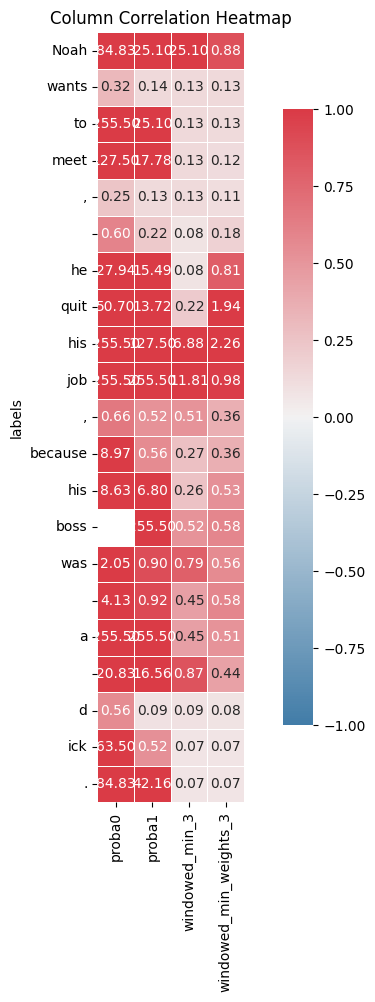

In [48]:
probas_df_only.index = check_df["labels"]
plot_heatmap(probas_df_only, figsize=(10,10))

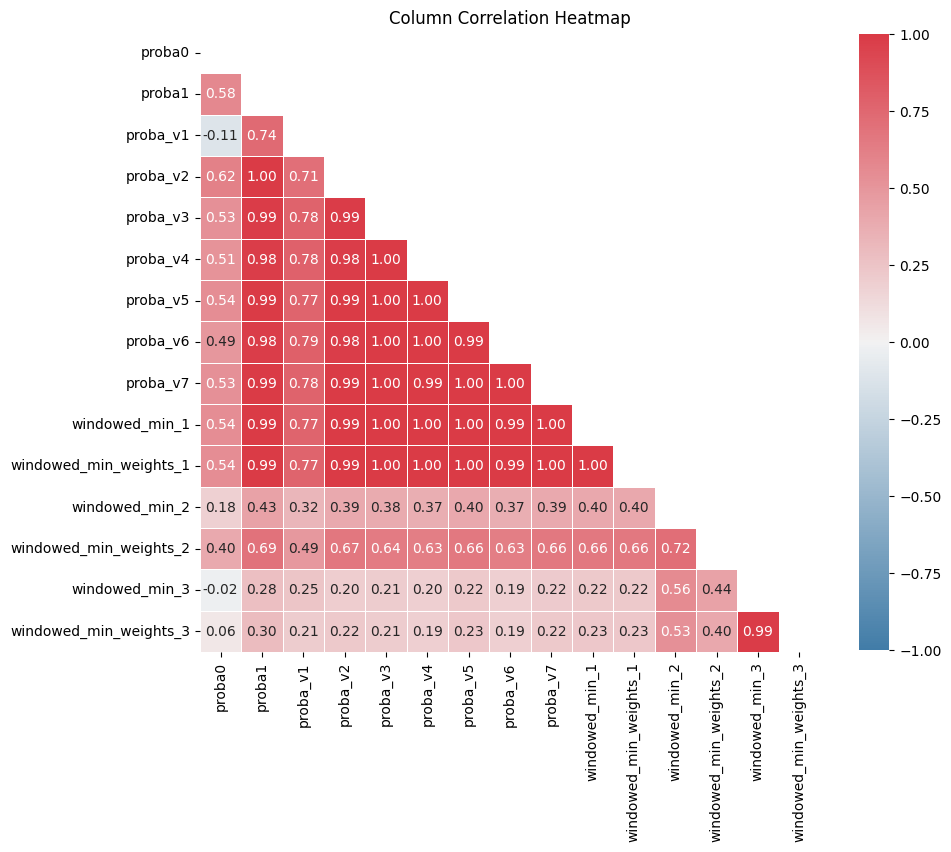

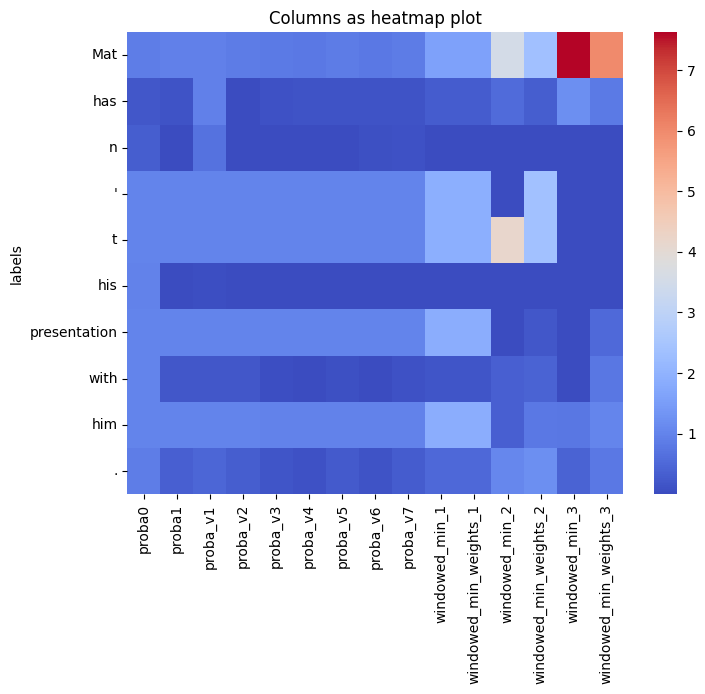

,proba0,proba1,proba_v1,proba_v2,proba_v3,proba_v4,proba_v5,proba_v6,proba_v7,windowed_min_1,windowed_min_weights_1,windowed_min_2,windowed_min_weights_2,windowed_min_3,windowed_min_weights_3
proba0,1.00,0.58,-0.11,0.62,0.53,0.51,0.54,0.49,0.53,0.54,0.54,0.18,0.40,-0.02,0.06
proba1,0.58,1.00,0.74,1.00,0.99,0.98,0.99,0.98,0.99,0.99,0.99,0.43,0.69,0.28,0.30
proba_v1,-0.11,0.74,1.00,0.71,0.78,0.78,0.77,0.79,0.78,0.77,0.77,0.32,0.49,0.25,0.21
proba_v2,0.62,1.00,0.71,1.00,0.99,0.98,0.99,0.98,0.99,0.99,0.99,0.39,0.67,0.20,0.22
proba_v3,0.53,0.99,0.78,0.99,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.38,0.64,0.21,0.21
proba_v4,0.51,0.98,0.78,0.98,1.00,1.00,1.00,1.00,0.99,1.00,1.00,0.37,0.63,0.20,0.19
proba_v5,0.54,0.99,0.77,0.99,1.00,1.00,1.00,0.99,1.00,1.00,1.00,0.40,0.66,0.22,0.23
proba_v6,0.49,0.98,0.79,0.98,1.00,1.00,0.99,1.00,1.00,0.99,0.99,0.37,0.63,0.19,0.19
proba_v7,0.53,0.99,0.78,0.99,1.00,0.99,1.00,1.00,1.00,1.00,1.00,0.39,0.66,0.22,0.22
windowed_min_1,0.54,0.99,0.77,0.99,1.00,1.00,1.00,0.99,1.00,1.00,1.00,0.40,0.66,0.22,0.23


In [63]:
plot_correlation_heatmap(probas_df_only, figsize=(10,10))

In [ ]:
plot_correlation_heatmap(probas_df_only, figsize=(10,10), spearman=True)

In [68]:
from argparse import Namespace
from run_sum_lora import Preprocess
from transformers import DataCollatorForSeq2Seq

In [69]:
args = Namespace(pad_to_max_length=False, max_source_length=512, use_clm=False, max_target_length=128, ignore_pad_token_for_loss=True, )
preprocess_function = Preprocess("dialogue", "summary", "summarize: ", tokenizer, args)
column_names = dataset["train"].column_names
train_dataset = dataset["train"].map(
            preprocess_function,
            batched=True,
            num_proc=16,
            remove_columns=column_names,
            load_from_cache_file=True,
            desc="Running tokenizer on dataset",
        )
max_target_length = args.max_target_length
label_pad_token_id = -100 if args.ignore_pad_token_for_loss else tokenizer.pad_token_id
data_collator = DataCollatorForSeq2Seq(
        tokenizer,
        model=model,
        label_pad_token_id=label_pad_token_id,
        pad_to_multiple_of=None,
    )
dataloader = DataLoader(
        train_dataset, collate_fn=data_collator, batch_size=1
    )

In [70]:
batch = next(iter(dataloader))

for ix, d in zip(range(idx+1), iter(dataloader)):
    batch = d
{k: v.shape for k, v in batch.items()}

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'input_ids': torch.Size([1, 70]),
 'attention_mask': torch.Size([1, 70]),
 'labels': torch.Size([1, 11]),
 'decoder_input_ids': torch.Size([1, 11])}

In [71]:
def get_one_step_proba(model, labels, input_ids, attention_mask, temperature=1.0, num_samples=None):
    original_lables = deepcopy(labels)
    labels = model._shift_right(labels)
    probas = []
    logits = []
    with torch.no_grad():
        encoder_output = model.encoder(input_ids, attention_mask)
        encoder_hidden_states = encoder_output[0]
        past_key_values = None
        
        for i in range(labels.shape[-1]-1):
            
            lbl = labels[..., :(i+1)]
                
            actual = original_lables[..., :(i+1)]
            
            decoder_outputs = model.decoder(input_ids=lbl, past_key_values=past_key_values, encoder_hidden_states=encoder_hidden_states, encoder_attention_mask=batch["attention_mask"], use_cache=True,)
            pkv=decoder_outputs.past_key_values
            sequence_output = decoder_outputs[0]
            if model.config.tie_word_embeddings:
                sequence_output = sequence_output * (model.model_dim**-0.5)
            lm_logits = model.lm_head(sequence_output).softmax(dim=-1).squeeze(0)
            proba = lm_logits[-1, actual[0, -1]].item()

            
            probas.append(proba)
            logits.append(lm_logits[-1].squeeze().cpu().tolist())
        return {"probas": probas, "logits": torch.tensor(logits)}
    

,baseline_jsd,model_1_jsd,model_1_to_2_jsd_1,model_1_to_2_jsd_2
labels,,,,
Mat,0.00,0.00,0.01,0.01
has,-0.00,0.00,0.20,0.20
n,0.00,0.00,1.00,1.00
',0.00,0.00,0.00,0.00
t,0.00,0.00,0.00,0.00
his,0.00,0.00,4.91,4.91
presentation,0.00,0.00,0.00,0.00
with,0.00,-0.00,0.90,0.90
him,0.00,0.00,0.01,0.01


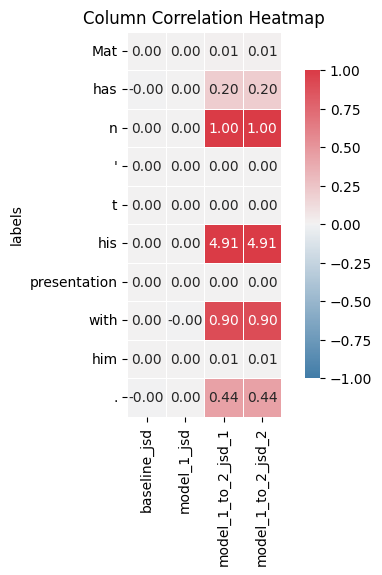

In [78]:
model = models["baseline"]
labels = batch["labels"]
input_ids = batch["input_ids"]
attention_mask = batch["attention_mask"]
baseline_proba_1 = get_one_step_proba(model, labels, input_ids, attention_mask, num_samples=10)
baseline_proba_2 = get_one_step_proba(model, labels, input_ids, attention_mask, num_samples=10)

model = models[0]
model_1_proba_1 = get_one_step_proba(model, labels, input_ids, attention_mask, num_samples=10)
model_1_proba_2 = get_one_step_proba(model, labels, input_ids, attention_mask, num_samples=10)

model = models[1]
model_2_proba_1 = get_one_step_proba(model, labels, input_ids, attention_mask, num_samples=10)

model_model_jsd_comp = pd.DataFrame(list(zip(calculate_jsd(baseline_proba_1["logits"], baseline_proba_2["logits"]), calculate_jsd(model_1_proba_1["logits"], model_1_proba_2["logits"]), calculate_jsd(model_1_proba_1["logits"], model_2_proba_1["logits"]), calculate_jsd(model_1_proba_2["logits"], model_2_proba_1["logits"]))), 
                                    columns=["baseline_jsd", "model_1_jsd", "model_1_to_2_jsd_1", "model_1_to_2_jsd_2"], index=df["labels"][:len(model_1_proba_1["logits"])])
model_model_jsd_comp
plot_heatmap(model_model_jsd_comp[["baseline_jsd", "model_1_jsd", "model_1_to_2_jsd_1", "model_1_to_2_jsd_2"]])



In [72]:
def get_one_step_proba_noisy(model, labels, input_ids, attention_mask, temperature=1.0, num_samples=None):
    original_lables = deepcopy(labels)
    labels = model._shift_right(labels)
    probas = []
    logits = []
    with torch.no_grad():
        encoder_output = model.encoder(input_ids, attention_mask)
        encoder_hidden_states = encoder_output[0]
        past_key_values = None
        sampled_probas = []
        sampled_logits = []
        for i in range(labels.shape[-1]-1):
            for j in range(num_samples):
                if i > 0:
                    lbl = labels[..., :(i)]
                    rands = torch.gather(input_ids, 1, input_ids.float().multinomial(1).long())
                    # rands = torch.randint(low=0, high=len(tokenizer), size=(labels.shape[0], 1))
                    lbl = torch.cat([lbl, rands], dim=1)
                else:
                    lbl = labels[..., :(i+1)]

                actual = original_lables[..., :(i+1)]
                decoder_outputs = model.decoder(input_ids=lbl, past_key_values=past_key_values, encoder_hidden_states=encoder_hidden_states, encoder_attention_mask=batch["attention_mask"], use_cache=True,)
                pkv=decoder_outputs.past_key_values
                sequence_output = decoder_outputs[0]
                if model.config.tie_word_embeddings:
                    sequence_output = sequence_output * (model.model_dim**-0.5)
                lm_logits = model.lm_head(sequence_output).softmax(dim=-1).squeeze(0)
                proba = lm_logits[-1, actual[0, -1]].item()
                sampled_probas.append(proba)
                lgts=lm_logits[-1].squeeze().cpu()
                sampled_logits.append(lgts)

            
            probas.append(np.mean(sampled_probas))
            logits.append(torch.stack(sampled_logits).mean(0))
        return {"probas": probas, "logits": torch.stack(logits)}
    

,baseline_jsd,model_1_jsd,model_1_to_2_jsd_1,model_1_to_2_jsd_2
labels,,,,
Mat,0.00,0.00,0.01,0.01
has,0.45,0.14,0.46,0.34
n,0.36,0.09,0.46,0.33
',0.29,0.11,0.41,0.28
t,0.21,0.09,0.33,0.27
his,0.20,0.09,0.27,0.14
presentation,0.16,0.12,0.26,0.12
with,0.16,0.11,0.26,0.13
him,0.15,0.05,0.16,0.12


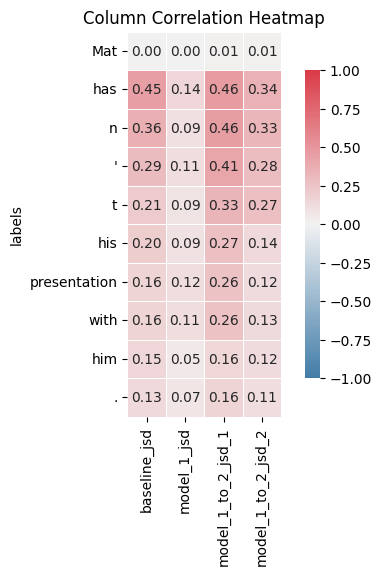

In [73]:
model = models["baseline"]
labels = batch["labels"]
input_ids = batch["input_ids"]
attention_mask = batch["attention_mask"]
baseline_proba_1 = get_one_step_proba_noisy(model, labels, input_ids, attention_mask, num_samples=10)
baseline_proba_2 = get_one_step_proba_noisy(model, labels, input_ids, attention_mask, num_samples=10)

model = models[0]
model_1_proba_1 = get_one_step_proba_noisy(model, labels, input_ids, attention_mask, num_samples=10)
model_1_proba_2 = get_one_step_proba_noisy(model, labels, input_ids, attention_mask, num_samples=10)

model = models[1]
model_2_proba_1 = get_one_step_proba_noisy(model, labels, input_ids, attention_mask, num_samples=10)

model_model_jsd_comp = pd.DataFrame(list(zip(calculate_jsd(baseline_proba_1["logits"], baseline_proba_2["logits"]), calculate_jsd(model_1_proba_1["logits"], model_1_proba_2["logits"]), calculate_jsd(model_1_proba_1["logits"], model_2_proba_1["logits"]), calculate_jsd(model_1_proba_2["logits"], model_2_proba_1["logits"]))), 
                                    columns=["baseline_jsd", "model_1_jsd", "model_1_to_2_jsd_1", "model_1_to_2_jsd_2"], index=df["labels"][:len(model_1_proba_1["logits"])])
model_model_jsd_comp
plot_heatmap(model_model_jsd_comp[["baseline_jsd", "model_1_jsd", "model_1_to_2_jsd_1", "model_1_to_2_jsd_2"]])



In [75]:


def get_two_step_proba(model, labels, input_ids, attention_mask, temperature=1.0, num_samples=10):
    original_lables = deepcopy(labels)
    labels = model._shift_right(labels)
    probas = []
    logits = []
    with torch.no_grad():
        encoder_output = model.encoder(input_ids, attention_mask)
        encoder_hidden_states = encoder_output[0]
        past_key_values = None
        
        for i in range(labels.shape[-1]-2):
            lbl = labels[..., :(i+1)]
            actual = original_lables[..., :(i+1)]
            decoder_outputs = model.decoder(input_ids=lbl, past_key_values=past_key_values, encoder_hidden_states=encoder_hidden_states, encoder_attention_mask=attention_mask, use_cache=True,)
            pkv=decoder_outputs.past_key_values
            sequence_output = decoder_outputs[0]
            if model.config.tie_word_embeddings:
                sequence_output = sequence_output * (model.model_dim**-0.5)
            lm_logits = model.lm_head(sequence_output).softmax(dim=-1).squeeze(0)
            proba = lm_logits[-1, actual[0, -1]].item()

            if i == 0:
                probas.append(proba)
                logits.append(lm_logits[-1].squeeze().cpu().tolist())
            index = (lm_logits[-1]).multinomial(num_samples=num_samples, replacement=True)
            # print(actual[..., -1], proba, index)
            actual = original_lables[..., :(i+2)]
            new_logits = []
            new_probas = []
            for idx in index:

                lbx = torch.cat([lbl, idx.unsqueeze(0).unsqueeze(0)], dim=-1)
                decoder_outputs = model.decoder(input_ids=lbx, past_key_values=pkv, encoder_hidden_states=encoder_hidden_states, encoder_attention_mask=attention_mask, use_cache=True,)
                sequence_output = decoder_outputs[0]
                if model.config.tie_word_embeddings:
                    sequence_output = sequence_output * (model.model_dim**-0.5)
                lm_logits = model.lm_head(sequence_output).softmax(dim=-1).squeeze(0)
                proba = lm_logits[-1, actual[0, -1]].item()
                new_probas.append(proba)
                new_logits.append(lm_logits[-1].squeeze().cpu().tolist())
            logits.append(np.mean(new_logits, axis=0))
            probas.append(np.mean(new_probas))
            past_key_values = pkv
    return {"probas": probas, "logits": torch.tensor(np.array(logits))}

/tmp/ipykernel_115403/1718308099.py:44: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return {"probas": probas, "logits": torch.tensor(logits)}


,baseline_jsd,model_1_jsd,model_1_to_2_jsd_1,model_1_to_2_jsd_2
labels,,,,
Mat,0.00,-0.00,0.01,0.01
has,0.00,0.09,0.17,0.25
n,0.25,0.27,0.64,1.59
',0.13,0.14,2.10,2.40
t,-0.00,0.00,0.00,0.00
his,0.00,-0.00,2.79,2.79
presentation,0.05,0.00,4.56,4.58
with,-0.00,0.00,0.63,0.63
him,0.19,0.31,0.61,2.33


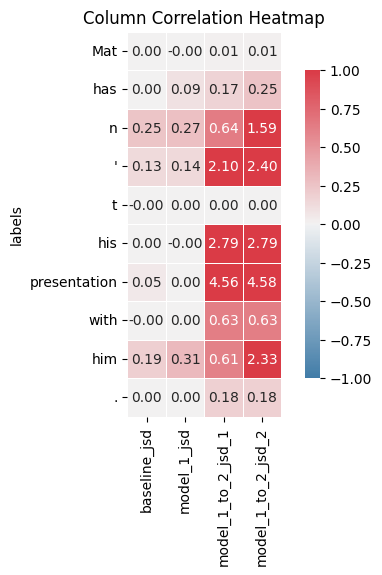

In [76]:
labels = batch["labels"]
input_ids = batch["input_ids"]
attention_mask = batch["attention_mask"]
model = models["baseline"]
baseline_proba_1 = get_two_step_proba(model, labels, input_ids, attention_mask, num_samples=20)
baseline_proba_2 = get_two_step_proba(model, labels, input_ids, attention_mask, num_samples=20)

model = models[0]
model_1_proba_1 = get_two_step_proba(model, labels, input_ids, attention_mask, num_samples=20)
model_1_proba_2 = get_two_step_proba(model, labels, input_ids, attention_mask, num_samples=20)

model = models[1]
model_2_proba_1 = get_two_step_proba(model, labels, input_ids, attention_mask, num_samples=20)

model_model_jsd_comp = pd.DataFrame(list(zip(calculate_jsd(baseline_proba_1["logits"], baseline_proba_2["logits"]), calculate_jsd(model_1_proba_1["logits"], model_1_proba_2["logits"]), calculate_jsd(model_1_proba_1["logits"], model_2_proba_1["logits"]), calculate_jsd(model_1_proba_2["logits"], model_2_proba_1["logits"]))), 
                                    columns=["baseline_jsd", "model_1_jsd", "model_1_to_2_jsd_1", "model_1_to_2_jsd_2"], index=df["labels"][:len(model_1_proba_1["logits"])])
model_model_jsd_comp
plot_heatmap(model_model_jsd_comp[["baseline_jsd", "model_1_jsd", "model_1_to_2_jsd_1", "model_1_to_2_jsd_2"]])






In [209]:
data_collator = DataCollatorForSeq2Seq(
        tokenizer,
        model=model,
        label_pad_token_id=0,
        pad_to_multiple_of=None,
    )
dataloader = DataLoader(
        train_dataset, collate_fn=data_collator, batch_size=1
    )
batch = next(iter(dataloader))
{k: v.shape for k, v in batch.items()}

def recursive_detach(t):
    if torch.is_tensor(t):
        return t.detach()
    elif isinstance(t, (list)):
        return list(map(recursive_detach, t))
    elif isinstance(t, (tuple)):
        return tuple(map(recursive_detach, t))
    elif isinstance(t, (dict)):
        return {k: recursive_detach(v) for k, v in t.items()}
    elif t is None:
        return t
    else:
        raise ValueError

def run_decoder_step(model, input_ids, past_key_values, encoder_hidden_states, attention_mask, actual, num_samples, device):
    # past_key_values = recursive_to_device(past_key_values, device)
    decoder_outputs = model.decoder(input_ids=input_ids, past_key_values=past_key_values, encoder_hidden_states=encoder_hidden_states, encoder_attention_mask=attention_mask, use_cache=True,)
    # past_key_values = recursive_to_device(past_key_values, torch.device("cpu"))
    sequence_output = decoder_outputs[0]
    if model.config.tie_word_embeddings:
        sequence_output = sequence_output * (model.model_dim**-0.5)
    lm_logits = model.lm_head(sequence_output).softmax(dim=-1)
    proba = torch.gather(lm_logits[:, -1], 1, actual[:, -1].unsqueeze(1))
    # proba = lm_logits[:, -1, actual[0, -1]].detach().cpu()
    logits = lm_logits[:, -1].detach()
    samples = None
    if num_samples:
        samples = (lm_logits[:, -1]/10.0).multinomial(num_samples=num_samples, replacement=True).detach()
    return {"proba": proba, "logits": logits, "samples": samples, "past_key_values": past_key_values}
    

    
def get_two_step_proba(model, labels, input_ids, attention_mask, temperature=1.0, num_samples=5):
    original_lables = deepcopy(labels)
    labels = model._shift_right(labels)
    probas = []
    logits = []
    with torch.no_grad():
        encoder_output = model.encoder(input_ids, attention_mask)
        encoder_hidden_states = encoder_output[0].detach()
        past_key_values = None
        
        for i in range(labels.shape[-1]-3):
            lbl = labels[..., :(i+1)]
            actual = original_lables[..., :(i+1)]
            decoder_step_out = run_decoder_step(model, lbl, None, encoder_hidden_states, attention_mask, actual, num_samples, labels.device)
            past_key_values = decoder_step_out["past_key_values"]
            if i == 0:
                proba = decoder_step_out["proba"]
                logits.append(decoder_step_out["logits"].unsqueeze(-1))
                probas.append(proba)
            
            index = decoder_step_out["samples"]
            del decoder_step_out
            # print(actual[..., -1], proba, index)
            actual = original_lables[..., :(i+2)]
            new_probas = []
            new_logits = []
            probas_l2 = []
            logits_l2 = []
            for j in range(index.shape[1]):
                idx = index[:, j].unsqueeze(-1)
                lbx = torch.cat([lbl, idx], dim=-1)
                decoder_step_out = run_decoder_step(model, lbx, past_key_values, encoder_hidden_states, attention_mask,actual, num_samples, labels.device)
                
                proba = decoder_step_out["proba"]
                new_probas.append(proba)
                new_logits.append(decoder_step_out["logits"].unsqueeze(-1))
                del decoder_step_out
            
            new_probas = torch.cat(new_probas, dim=1).mean(-1).unsqueeze(-1)
            new_logits = torch.cat(new_logits, dim=-1).mean(-1).unsqueeze(-1)
            probas.append(new_probas) # 
            logits.append(new_logits)
            
        probas = torch.cat(probas, dim=1)
        logits = torch.cat(logits, dim=-1).transpose(1,2)
    return {"probas": probas, "logits": logits}

model = models["baseline"]
labels = batch["labels"]
input_ids = batch["input_ids"]
labels
attention_mask = batch["attention_mask"]
baseline_proba = get_two_step_proba(model, labels, input_ids, attention_mask)

baseline_proba["logits"].shape


{'input_ids': torch.Size([1, 30]),
 'attention_mask': torch.Size([1, 30]),
 'labels': torch.Size([1, 11]),
 'decoder_input_ids': torch.Size([1, 11])}

tensor([[21542, 13635,  5081,    11,    56,   830, 16637,   128,  5721,     5,
             1]])

torch.Size([1, 9, 32128])

,baseline_jsd,model_1_jsd,model_1_to_2_jsd_1,model_1_to_2_jsd_2
labels,,,,
Amanda,0.00,0.00,0.00,0.00
baked,0.00,0.00,0.42,0.42
cookies,0.30,0.02,1.97,1.41
and,0.00,-0.00,1.38,1.38
will,0.02,0.00,0.09,0.08
bring,0.11,0.11,0.05,0.27
Jerry,0.02,0.00,0.82,0.82
some,0.00,0.10,3.39,1.14
tomorrow,0.00,0.35,0.01,0.17


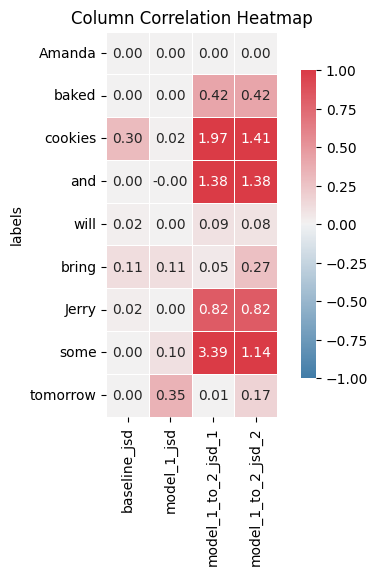

In [211]:
model = models["baseline"]
baseline_proba_1 = get_two_step_proba(model, labels, input_ids, attention_mask, num_samples=20)
baseline_proba_1["probas"] = baseline_proba_1["probas"].squeeze()
baseline_proba_1["logits"] = baseline_proba_1["logits"].squeeze().tolist()
baseline_proba_2 = get_two_step_proba(model, labels, input_ids, attention_mask, num_samples=20)
baseline_proba_2["probas"] = baseline_proba_2["probas"].squeeze()
baseline_proba_2["logits"] = baseline_proba_2["logits"].squeeze().tolist()

model = models[0]
model_1_proba_1 = get_two_step_proba(model, labels, input_ids, attention_mask, num_samples=20)
model_1_proba_1["probas"] = model_1_proba_1["probas"].squeeze()
model_1_proba_1["logits"] = model_1_proba_1["logits"].squeeze()
model_1_proba_2 = get_two_step_proba(model, labels, input_ids, attention_mask, num_samples=20)
model_1_proba_2["probas"] = model_1_proba_2["probas"].squeeze()
model_1_proba_2["logits"] = model_1_proba_2["logits"].squeeze().tolist()

model = models[1]
model_2_proba_1 = get_two_step_proba(model, labels, input_ids, attention_mask, num_samples=20)
model_2_proba_1["probas"] = model_2_proba_1["probas"].squeeze()
model_2_proba_1["logits"] = model_2_proba_1["logits"].squeeze().tolist()

model_model_jsd_comp = pd.DataFrame(list(zip(calculate_jsd(baseline_proba_1["logits"], baseline_proba_2["logits"]), calculate_jsd(model_1_proba_1["logits"], model_1_proba_2["logits"]), calculate_jsd(model_1_proba_1["logits"], model_2_proba_1["logits"]), calculate_jsd(model_1_proba_2["logits"], model_2_proba_1["logits"]))), 
                                    columns=["baseline_jsd", "model_1_jsd", "model_1_to_2_jsd_1", "model_1_to_2_jsd_2"], index=df["labels"][:len(model_1_proba_1["logits"])])
model_model_jsd_comp
plot_heatmap(model_model_jsd_comp[["baseline_jsd", "model_1_jsd", "model_1_to_2_jsd_1", "model_1_to_2_jsd_2"]])



,baseline_jsd,model_1_jsd,model_1_to_2_jsd_1,model_1_to_2_jsd_2
labels,,,,
Amanda,0.00,0.00,0.00,0.00
baked,0.00,0.00,0.42,0.45
cookies,0.40,0.45,2.79,1.99
and,0.00,-0.00,1.59,1.59
will,0.02,0.01,0.08,0.07
bring,0.44,0.13,0.14,0.20
Jerry,0.02,-0.00,0.96,0.96
some,0.08,0.00,2.46,2.46
tomorrow,0.00,0.00,0.00,0.00


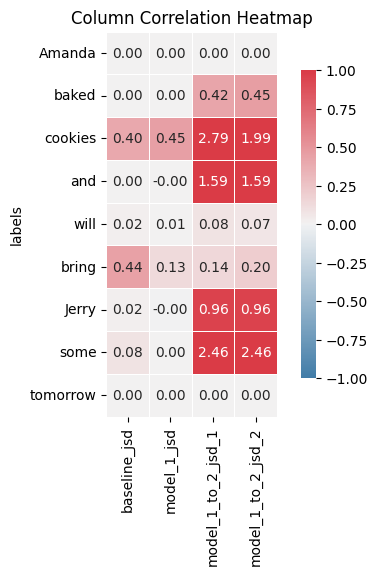

In [210]:
model = models["baseline"]
baseline_proba_1 = get_two_step_proba(model, labels, input_ids, attention_mask, num_samples=20)
baseline_proba_1["probas"] = baseline_proba_1["probas"].squeeze()
baseline_proba_1["logits"] = baseline_proba_1["logits"].squeeze().tolist()
baseline_proba_2 = get_two_step_proba(model, labels, input_ids, attention_mask, num_samples=20)
baseline_proba_2["probas"] = baseline_proba_2["probas"].squeeze()
baseline_proba_2["logits"] = baseline_proba_2["logits"].squeeze().tolist()

model = models[0]
model_1_proba_1 = get_two_step_proba(model, labels, input_ids, attention_mask, num_samples=20)
model_1_proba_1["probas"] = model_1_proba_1["probas"].squeeze()
model_1_proba_1["logits"] = model_1_proba_1["logits"].squeeze()
model_1_proba_2 = get_two_step_proba(model, labels, input_ids, attention_mask, num_samples=20)
model_1_proba_2["probas"] = model_1_proba_2["probas"].squeeze()
model_1_proba_2["logits"] = model_1_proba_2["logits"].squeeze().tolist()

model = models[1]
model_2_proba_1 = get_two_step_proba(model, labels, input_ids, attention_mask, num_samples=20)
model_2_proba_1["probas"] = model_2_proba_1["probas"].squeeze()
model_2_proba_1["logits"] = model_2_proba_1["logits"].squeeze().tolist()

model_model_jsd_comp = pd.DataFrame(list(zip(calculate_jsd(baseline_proba_1["logits"], baseline_proba_2["logits"]), calculate_jsd(model_1_proba_1["logits"], model_1_proba_2["logits"]), calculate_jsd(model_1_proba_1["logits"], model_2_proba_1["logits"]), calculate_jsd(model_1_proba_2["logits"], model_2_proba_1["logits"]))), 
                                    columns=["baseline_jsd", "model_1_jsd", "model_1_to_2_jsd_1", "model_1_to_2_jsd_2"], index=df["labels"][:len(model_1_proba_1["logits"])])
model_model_jsd_comp
plot_heatmap(model_model_jsd_comp[["baseline_jsd", "model_1_jsd", "model_1_to_2_jsd_1", "model_1_to_2_jsd_2"]])



In [97]:
from collections import Counter
def get_three_step_proba(model, labels, input_ids, attention_mask, temperature=1.0, num_samples=10):
    original_lables = deepcopy(labels)
    labels = model._shift_right(labels)
    probas = []
    logits = []
    with torch.no_grad():
        encoder_output = model.encoder(input_ids, attention_mask)
        encoder_hidden_states = encoder_output[0]
        past_key_values = None
        
        for i in range(labels.shape[-1]-3):
            lbl = labels[..., :(i+1)]
            actual = original_lables[..., :(i+1)]
            decoder_outputs = model.decoder(input_ids=lbl, past_key_values=past_key_values, encoder_hidden_states=encoder_hidden_states, encoder_attention_mask=batch["attention_mask"], use_cache=True,)
            pkv=decoder_outputs.past_key_values
            sequence_output = decoder_outputs[0]
            if model.config.tie_word_embeddings:
                sequence_output = sequence_output * (model.model_dim**-0.5)
            lm_logits = model.lm_head(sequence_output).softmax(dim=-1).squeeze(0)
            

            if i == 0:
                proba = lm_logits[-1, actual[0, -1]].item()
                logits.append(lm_logits[-1].squeeze().cpu().tolist())
                probas.append(proba)
                
            index = (lm_logits[-1]).multinomial(num_samples=num_samples, replacement=True)
            # print(actual[..., -1], proba, index)
            actual = original_lables[..., :(i+2)]
            new_probas = []
            new_logits = []
            probas_l2 = []
            logits_l2 = []
            for idx in index:

                lbx = torch.cat([lbl, idx.unsqueeze(0).unsqueeze(0)], dim=-1)
                decoder_outputs = model.decoder(input_ids=lbx, past_key_values=pkv, encoder_hidden_states=encoder_hidden_states, encoder_attention_mask=batch["attention_mask"], use_cache=True,)
                sequence_output = decoder_outputs[0]
                if model.config.tie_word_embeddings:
                    sequence_output = sequence_output * (model.model_dim**-0.5)
                lm_logits = model.lm_head(sequence_output).softmax(dim=-1).squeeze(0)
                if i == 0:
                    proba = lm_logits[-1, actual[0, -1]].item()
                    new_probas.append(proba)
                    new_logits.append(lm_logits[-1].squeeze().cpu().tolist())
                pkv_v2 = decoder_outputs.past_key_values
                
                index_l2 = (lm_logits[-1]).multinomial(num_samples=num_samples, replacement=True)
                actual = original_lables[..., :(i+3)]
                
                for idx in index_l2:

                    lby = torch.cat([lbx, idx.unsqueeze(0).unsqueeze(0)], dim=-1)
                    decoder_outputs = model.decoder(input_ids=lby, past_key_values=pkv_v2, encoder_hidden_states=encoder_hidden_states, encoder_attention_mask=batch["attention_mask"], use_cache=True,)
                    sequence_output = decoder_outputs[0]
                    if model.config.tie_word_embeddings:
                        sequence_output = sequence_output * (model.model_dim**-0.5)
                    lm_logits = model.lm_head(sequence_output).softmax(dim=-1).squeeze(0)
                    proba = lm_logits[-1, actual[0, -1]].item()
                    probas_l2.append(proba)
                    logits_l2.append(lm_logits[-1].squeeze().cpu().tolist())
                
                
            if i == 0:
                probas.append(np.mean(new_probas))
                logits.append(np.mean(new_logits, axis=0))
            probas.append(np.mean(probas_l2))
            logits.append(np.mean(logits_l2, axis=0))
            past_key_values = pkv
    return {"probas": probas, "logits": torch.tensor(logits)}


def get_three_step_proba_cached(model, labels, input_ids, attention_mask, temperature=1.0, num_samples=10):
    original_lables = deepcopy(labels)
    labels = model._shift_right(labels)
    probas = []
    logits = []
    with torch.no_grad():
        encoder_output = model.encoder(input_ids, attention_mask)
        encoder_hidden_states = encoder_output[0]
        past_key_values = None
        
        for i in range(labels.shape[-1]-3):
            lbl = labels[..., :(i+1)]
            actual = original_lables[..., :(i+1)]
            decoder_outputs = model.decoder(input_ids=lbl, past_key_values=past_key_values, encoder_hidden_states=encoder_hidden_states, encoder_attention_mask=attention_mask, use_cache=True,)
            pkv=decoder_outputs.past_key_values
            sequence_output = decoder_outputs[0]
            if model.config.tie_word_embeddings:
                sequence_output = sequence_output * (model.model_dim**-0.5)
            lm_logits = model.lm_head(sequence_output).softmax(dim=-1).squeeze(0)
            

            if i == 0:
                proba = lm_logits[-1, actual[0, -1]].item()
                logits.append(lm_logits[-1].squeeze().cpu().tolist())
                probas.append(proba)
                
            index = (lm_logits[-1]).multinomial(num_samples=num_samples, replacement=True)
            
            index_ctr = Counter(index.tolist())
            index = index_ctr.keys()
            # print(actual[..., -1], proba, index)
            actual = original_lables[..., :(i+2)]
            new_probas = []
            new_logits = []
            probas_l2 = []
            logits_l2 = []
            weight_div = 0
            for idx in index:
                idx_wt = index_ctr[idx]
                idx = torch.tensor(idx)
                lbx = torch.cat([lbl, idx.unsqueeze(0).unsqueeze(0)], dim=-1)
                decoder_outputs = model.decoder(input_ids=lbx, past_key_values=pkv, encoder_hidden_states=encoder_hidden_states, encoder_attention_mask=attention_mask, use_cache=True,)
                sequence_output = decoder_outputs[0]
                if model.config.tie_word_embeddings:
                    sequence_output = sequence_output * (model.model_dim**-0.5)
                lm_logits = model.lm_head(sequence_output).softmax(dim=-1).squeeze(0)
                if i == 0:
                    proba = lm_logits[-1, actual[0, -1]].item()
                    new_probas.append(idx_wt * proba)
                    new_logits.append((idx_wt*lm_logits[-1].squeeze().cpu()).tolist())
                    
                pkv_v2 = decoder_outputs.past_key_values
                
                index_l2 = (lm_logits[-1]).multinomial(num_samples=20, replacement=True)
                index_ctr_l2 = Counter(index_l2.tolist())
                index_l2 = index_ctr_l2.keys()
                
                actual = original_lables[..., :(i+3)]
                
                for idx in index_l2:
                    idx_wt_l2 = index_ctr_l2[idx]
                    idx = torch.tensor(idx)
                    
                    lby = torch.cat([lbx, idx.unsqueeze(0).unsqueeze(0)], dim=-1)
                    decoder_outputs = model.decoder(input_ids=lby, past_key_values=pkv_v2, encoder_hidden_states=encoder_hidden_states, encoder_attention_mask=attention_mask, use_cache=True,)
                    sequence_output = decoder_outputs[0]
                    if model.config.tie_word_embeddings:
                        sequence_output = sequence_output * (model.model_dim**-0.5)
                    lm_logits = model.lm_head(sequence_output).softmax(dim=-1).squeeze(0)
                    proba = lm_logits[-1, actual[0, -1]].item()
                    probas_l2.append(idx_wt*idx_wt_l2* proba)
                    logits_l2.append((idx_wt*idx_wt_l2*lm_logits[-1].squeeze().cpu()).tolist())
                    weight_div += (idx_wt*idx_wt_l2)
                
                
            if i == 0:
                probas.append(np.sum(new_probas)/np.sum(list(index_ctr.values())))
                logits.append(np.sum(new_logits, axis=0)/np.sum(list(index_ctr.values())))
            probas.append(np.sum(probas_l2)/weight_div)
            logits.append(np.sum(logits_l2, axis=0)/weight_div)
            past_key_values = pkv
    return {"probas": probas, "logits": torch.tensor(np.array(logits))}

In [ ]:
def get_three_step_proba_non_fold(model, non_fold_model, labels, input_ids, attention_mask, temperature=1.0, num_samples=10):
    original_lables = deepcopy(labels)
    labels = model._shift_right(labels)
    probas = []
    logits = []
    with torch.no_grad():
        non_fold_encoder_hidden_states = non_fold_model.encoder(input_ids, attention_mask)[0]
        encoder_output = model.encoder(input_ids, attention_mask)
        encoder_hidden_states = encoder_output[0]
        past_key_values = None
        
        for i in range(labels.shape[-1]-3):
            lbl = labels[..., :(i+1)]
            actual = original_lables[..., :(i+1)]
            decoder_outputs = non_fold_model.decoder(input_ids=lbl, past_key_values=past_key_values, encoder_hidden_states=non_fold_encoder_hidden_states, encoder_attention_mask=attention_mask, use_cache=True,)
            pkv=decoder_outputs.past_key_values
            sequence_output = decoder_outputs[0]
            if model.config.tie_word_embeddings:
                sequence_output = sequence_output * (model.model_dim**-0.5)
            lm_logits = model.lm_head(sequence_output).softmax(dim=-1).squeeze(0)
            

            if i == 0:
                proba = lm_logits[-1, actual[0, -1]].item()
                logits.append(lm_logits[-1].squeeze().cpu().tolist())
                probas.append(proba)
                
            index = (lm_logits[-1]).multinomial(num_samples=num_samples, replacement=True)
            # print(actual[..., -1], proba, index)
            actual = original_lables[..., :(i+2)]
            new_probas = []
            new_logits = []
            probas_l2 = []
            logits_l2 = []
            for idx in index:

                lbx = torch.cat([lbl, idx.unsqueeze(0).unsqueeze(0)], dim=-1)
                decoder_outputs = model.decoder(input_ids=lbx, past_key_values=None, encoder_hidden_states=encoder_hidden_states, encoder_attention_mask=batch["attention_mask"], use_cache=True,)
                sequence_output = decoder_outputs[0]
                if model.config.tie_word_embeddings:
                    sequence_output = sequence_output * (model.model_dim**-0.5)
                lm_logits = model.lm_head(sequence_output).softmax(dim=-1).squeeze(0)
                if i == 0:
                    proba = lm_logits[-1, actual[0, -1]].item()
                    new_probas.append(proba)
                    new_logits.append(lm_logits[-1].squeeze().cpu().tolist())
                pkv_v2 = decoder_outputs.past_key_values
                
                index_l2 = (lm_logits[-1]).multinomial(num_samples=num_samples, replacement=True)
                actual = original_lables[..., :(i+3)]
                
                for idx in index_l2:

                    lby = torch.cat([lbx, idx.unsqueeze(0).unsqueeze(0)], dim=-1)
                    decoder_outputs = model.decoder(input_ids=lby, past_key_values=pkv_v2, encoder_hidden_states=encoder_hidden_states, encoder_attention_mask=batch["attention_mask"], use_cache=True,)
                    sequence_output = decoder_outputs[0]
                    if model.config.tie_word_embeddings:
                        sequence_output = sequence_output * (model.model_dim**-0.5)
                    lm_logits = model.lm_head(sequence_output).softmax(dim=-1).squeeze(0)
                    proba = lm_logits[-1, actual[0, -1]].item()
                    probas_l2.append(proba)
                    logits_l2.append(lm_logits[-1].squeeze().cpu().tolist())
                
                
            if i == 0:
                probas.append(np.mean(new_probas))
                logits.append(np.mean(new_logits, axis=0))
            probas.append(np.mean(probas_l2))
            logits.append(np.mean(logits_l2, axis=0))
            past_key_values = pkv
    return {"probas": probas, "logits": torch.tensor(logits)}

,baseline_jsd,model_1_jsd,model_1_to_2_jsd_1,model_1_to_2_jsd_2
labels,,,,
Mat,0.00,0.00,0.00,0.00
has,0.22,0.22,0.36,0.55
n,0.18,0.20,0.61,0.61
',0.57,0.68,0.84,0.64
t,0.53,0.34,0.47,0.81
his,0.00,0.00,2.46,2.46
presentation,0.03,0.02,5.45,5.45
with,0.69,0.93,0.85,0.63
him,0.81,0.03,1.41,1.65


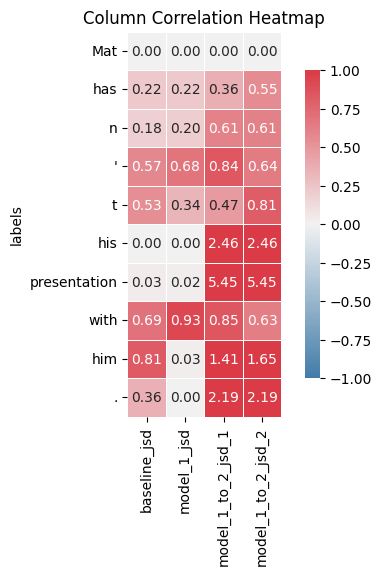

In [105]:
model = models["baseline"]
baseline_proba_1 = get_three_step_proba_non_fold(model,models["pretrained"], labels, input_ids, attention_mask, num_samples=10)
baseline_proba_2 = get_three_step_proba_non_fold(model,models["pretrained"], labels, input_ids, attention_mask, num_samples=10)

model = models[0]
model_1_proba_1 = get_three_step_proba_non_fold(model,models["pretrained"], labels, input_ids, attention_mask, num_samples=10)
model_1_proba_2 = get_three_step_proba_non_fold(model,models["pretrained"], labels, input_ids, attention_mask, num_samples=10)

model = models[1]
model_2_proba_1 = get_three_step_proba_non_fold(model,models["pretrained"], labels, input_ids, attention_mask, num_samples=10)

model_model_jsd_comp = pd.DataFrame(list(zip(calculate_jsd(baseline_proba_1["logits"], baseline_proba_2["logits"]), calculate_jsd(model_1_proba_1["logits"], model_1_proba_2["logits"]), calculate_jsd(model_1_proba_1["logits"], model_2_proba_1["logits"]), calculate_jsd(model_1_proba_2["logits"], model_2_proba_1["logits"]))), 
                                    columns=["baseline_jsd", "model_1_jsd", "model_1_to_2_jsd_1", "model_1_to_2_jsd_2"], index=df["labels"][:len(model_1_proba_1["logits"])])
model_model_jsd_comp
plot_heatmap(model_model_jsd_comp[["baseline_jsd", "model_1_jsd", "model_1_to_2_jsd_1", "model_1_to_2_jsd_2"]])



,baseline_jsd,model_1_jsd,model_1_to_2_jsd_1,model_1_to_2_jsd_2
labels,,,,
Mat,0.00,-0.00,0.01,0.01
has,0.00,0.01,0.16,0.10
n,0.07,0.07,0.40,0.36
',0.48,1.40,1.73,0.57
t,0.52,0.31,1.55,1.17
his,0.00,-0.00,2.79,2.79
presentation,0.04,0.01,4.67,4.20
with,0.41,0.28,1.70,3.76
him,0.03,0.01,0.62,0.77


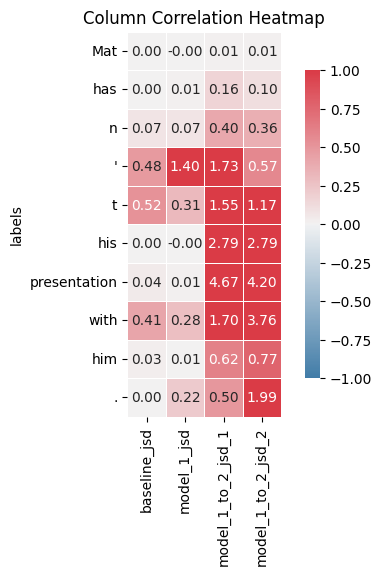

In [104]:
model = models["baseline"]
baseline_proba_1 = get_three_step_proba(model, labels, input_ids, attention_mask, num_samples=10)
baseline_proba_2 = get_three_step_proba(model, labels, input_ids, attention_mask, num_samples=10)

model = models[0]
model_1_proba_1 = get_three_step_proba(model, labels, input_ids, attention_mask, num_samples=10)
model_1_proba_2 = get_three_step_proba(model, labels, input_ids, attention_mask, num_samples=10)

model = models[1]
model_2_proba_1 = get_three_step_proba(model, labels, input_ids, attention_mask, num_samples=10)

model_model_jsd_comp = pd.DataFrame(list(zip(calculate_jsd(baseline_proba_1["logits"], baseline_proba_2["logits"]), calculate_jsd(model_1_proba_1["logits"], model_1_proba_2["logits"]), calculate_jsd(model_1_proba_1["logits"], model_2_proba_1["logits"]), calculate_jsd(model_1_proba_2["logits"], model_2_proba_1["logits"]))), 
                                    columns=["baseline_jsd", "model_1_jsd", "model_1_to_2_jsd_1", "model_1_to_2_jsd_2"], index=df["labels"][:len(model_1_proba_1["logits"])])
model_model_jsd_comp
plot_heatmap(model_model_jsd_comp[["baseline_jsd", "model_1_jsd", "model_1_to_2_jsd_1", "model_1_to_2_jsd_2"]])



,baseline_jsd,model_1_jsd,model_1_to_2_jsd_1,model_1_to_2_jsd_2
labels,,,,
Mat,0.00,0.00,0.02,0.02
has,0.36,0.31,0.15,0.51
n,0.08,0.22,0.38,0.65
',1.16,0.57,0.75,1.41
t,0.75,0.06,0.91,0.97
his,0.00,0.00,2.46,2.46
presentation,0.01,0.02,5.43,3.67
with,0.23,0.04,2.69,2.46
him,0.10,0.01,1.94,1.90


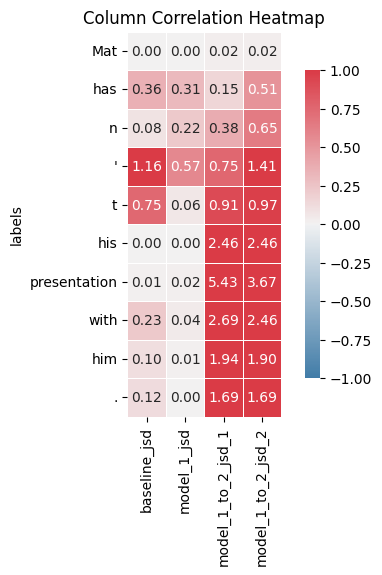

In [106]:
model = models["baseline"]
baseline_proba_1 = get_three_step_proba_non_fold(model,models["pretrained"], labels, input_ids, attention_mask, num_samples=10)
baseline_proba_2 = get_three_step_proba_non_fold(model,models["pretrained"], labels, input_ids, attention_mask, num_samples=10)

model = models[0]
model_1_proba_1 = get_three_step_proba_non_fold(model,models[1], labels, input_ids, attention_mask, num_samples=10)
model_1_proba_2 = get_three_step_proba_non_fold(model,models[1], labels, input_ids, attention_mask, num_samples=10)

model = models[1]
model_2_proba_1 = get_three_step_proba_non_fold(model,models[0], labels, input_ids, attention_mask, num_samples=10)

model_model_jsd_comp = pd.DataFrame(list(zip(calculate_jsd(baseline_proba_1["logits"], baseline_proba_2["logits"]), calculate_jsd(model_1_proba_1["logits"], model_1_proba_2["logits"]), calculate_jsd(model_1_proba_1["logits"], model_2_proba_1["logits"]), calculate_jsd(model_1_proba_2["logits"], model_2_proba_1["logits"]))), 
                                    columns=["baseline_jsd", "model_1_jsd", "model_1_to_2_jsd_1", "model_1_to_2_jsd_2"], index=df["labels"][:len(model_1_proba_1["logits"])])
model_model_jsd_comp
plot_heatmap(model_model_jsd_comp[["baseline_jsd", "model_1_jsd", "model_1_to_2_jsd_1", "model_1_to_2_jsd_2"]])



==


,baseline_jsd,model_1_jsd,model_1_to_2_jsd_1,model_1_to_2_jsd_2
labels,,,,
Mat,0.00,-0.00,0.01,0.01
has,0.00,0.00,0.16,0.15
n,0.10,0.26,0.96,1.42
',0.11,0.20,0.53,0.45
t,0.12,0.14,1.13,0.98
his,0.00,0.00,2.79,2.79
presentation,0.14,0.03,4.17,4.79
with,0.06,0.01,1.37,1.45
him,0.06,0.10,0.98,0.47


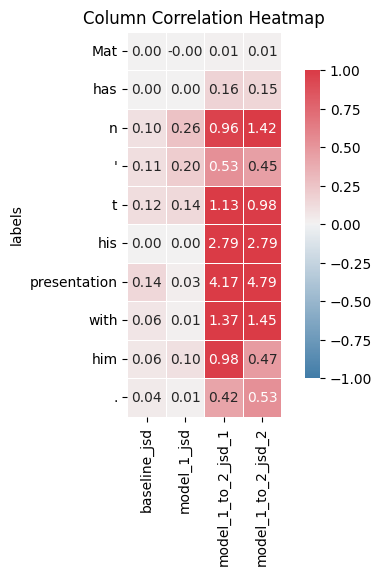

In [109]:
model = models["baseline"]
print("==")
baseline_proba_1 = get_three_step_proba_cached(model, labels, input_ids, attention_mask, num_samples=40)
baseline_proba_2 = get_three_step_proba_cached(model, labels, input_ids, attention_mask, num_samples=40)

model = models[0]
model_1_proba_1 = get_three_step_proba_cached(model, labels, input_ids, attention_mask, num_samples=40)
model_1_proba_2 = get_three_step_proba_cached(model, labels, input_ids, attention_mask, num_samples=40)

model = models[1]
model_2_proba_1 = get_three_step_proba_cached(model, labels, input_ids, attention_mask, num_samples=40)

model_model_jsd_comp = pd.DataFrame(list(zip(calculate_jsd(baseline_proba_1["logits"], baseline_proba_2["logits"]), calculate_jsd(model_1_proba_1["logits"], model_1_proba_2["logits"]), calculate_jsd(model_1_proba_1["logits"], model_2_proba_1["logits"]), calculate_jsd(model_1_proba_2["logits"], model_2_proba_1["logits"]))), 
                                    columns=["baseline_jsd", "model_1_jsd", "model_1_to_2_jsd_1", "model_1_to_2_jsd_2"], index=df["labels"][:len(model_1_proba_1["logits"])])
model_model_jsd_comp
plot_heatmap(model_model_jsd_comp[["baseline_jsd", "model_1_jsd", "model_1_to_2_jsd_1", "model_1_to_2_jsd_2"]])



,baseline_jsd,model_1_jsd,model_1_to_2_jsd_1,model_1_to_2_jsd_2
labels,,,,
Mat,0.00,-0.00,0.01,0.01
has,0.01,0.00,0.18,0.20
n,0.03,0.02,0.41,0.44
',0.17,0.42,0.70,1.19
t,0.06,0.37,0.80,0.67
his,0.00,-0.00,2.79,2.79
presentation,0.02,0.01,2.44,2.46
with,0.12,0.27,1.85,3.91
him,0.09,0.01,0.87,0.59


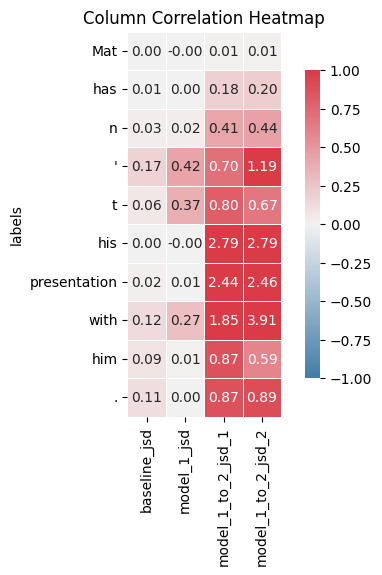

In [110]:
model = models["baseline"]
baseline_proba_1 = get_three_step_proba(model, labels, input_ids, attention_mask, num_samples=20)
baseline_proba_2 = get_three_step_proba(model, labels, input_ids, attention_mask, num_samples=20)

model = models[0]
model_1_proba_1 = get_three_step_proba(model, labels, input_ids, attention_mask, num_samples=20)
model_1_proba_2 = get_three_step_proba(model, labels, input_ids, attention_mask, num_samples=20)

model = models[1]
model_2_proba_1 = get_three_step_proba(model, labels, input_ids, attention_mask, num_samples=20)

model_model_jsd_comp = pd.DataFrame(list(zip(calculate_jsd(baseline_proba_1["logits"], baseline_proba_2["logits"]), calculate_jsd(model_1_proba_1["logits"], model_1_proba_2["logits"]), calculate_jsd(model_1_proba_1["logits"], model_2_proba_1["logits"]), calculate_jsd(model_1_proba_2["logits"], model_2_proba_1["logits"]))), 
                                    columns=["baseline_jsd", "model_1_jsd", "model_1_to_2_jsd_1", "model_1_to_2_jsd_2"], index=df["labels"][:len(model_1_proba_1["logits"])])
model_model_jsd_comp
plot_heatmap(model_model_jsd_comp[["baseline_jsd", "model_1_jsd", "model_1_to_2_jsd_1", "model_1_to_2_jsd_2"]])



In [59]:
ndf = df[["proba0", "proba1", "labels", "label_ids", 'proba_v1', 'proba_v2', 'proba_v3', "proba_v4", "proba_v5", "proba_v6", "proba_v7"]].head(10)
ndf["1st_model_3_hop"] = model_1_proba["probas"]
ndf["2nd_model_3_hop"] = model_2_proba["probas"]
ndf["baseline_model_3_hop"] = baseline_proba["probas"]
ndf["pretrained_3_hop"] = pretrained_proba["probas"]



with torch.no_grad():
    jsd_m = 0.5 * (model_1_proba["logits"] + model_2_proba["logits"])
    jsd = 0.5 * nn.KLDivLoss(reduction='none', log_target=False)(torch.log(model_1_proba["logits"]), jsd_m) + 0.5 * nn.KLDivLoss(reduction='none', log_target=False)(torch.log(model_2_proba["logits"]), jsd_m)
    jsd = jsd.sum(-1).tolist()
    kl_divs_1_2 = nn.KLDivLoss(reduction='none', log_target=False)(torch.log(model_1_proba["logits"]), model_2_proba["logits"]).sum(-1).tolist()
    kl_divs_2_1 = nn.KLDivLoss(reduction='none', log_target=False)(torch.log(model_2_proba["logits"]), model_1_proba["logits"]).sum(-1).tolist()
ndf["kl_divs_[1_2]_3_hop"] = kl_divs_1_2
ndf["kl_divs_[2_1]_3_hop"] = kl_divs_2_1
ndf["jsd_3_hop"] = jsd

view_df = ndf[["proba0", "proba1", "labels", "label_ids", 'proba_v1', 'proba_v2', 'proba_v3', "proba_v4", "proba_v5", "proba_v6", "proba_v7"]]
view_df[["1st_model_1_hop", "2nd_model_1_hop", "baseline_model_1_hop", "pretrained_1_hop", "jsd_1_hop"]] = one_hop[["1st_model_1_hop", "2nd_model_1_hop", "baseline_model_1_hop", "pretrained_1_hop", "jsd_1_hop"]]
view_df[["1st_model_2_hop", "2nd_model_2_hop", "baseline_model_2_hop", "pretrained_2_hop", "jsd_2_hop"]] = two_hop[["1st_model_2_hop", "2nd_model_2_hop", "baseline_model_2_hop", "pretrained_2_hop", "jsd_2_hop"]]
view_df[["1st_model_3_hop", "2nd_model_3_hop", "baseline_model_3_hop", "pretrained_3_hop", "jsd_3_hop"]] = ndf[["1st_model_3_hop", "2nd_model_3_hop", "baseline_model_3_hop", "pretrained_3_hop", "jsd_3_hop"]]

view_df 

/tmp/ipykernel_101273/1347322656.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  view_df[["1st_model_1_hop", "2nd_model_1_hop", "baseline_model_1_hop", "pretrained_1_hop", "jsd_1_hop"]] = one_hop[["1st_model_1_hop", "2nd_model_1_hop", "baseline_model_1_hop", "pretrained_1_hop", "jsd_1_hop"]]
/tmp/ipykernel_101273/1347322656.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  view_df[["1st_model_1_hop", "2nd_model_1_hop", "baseline_model_1_hop", "pretrained_1_hop", "jsd_1_hop"]] = one_hop[["1st_model_1

,proba0,proba1,labels,label_ids,proba_v1,proba_v2,proba_v3,proba_v4,proba_v5,proba_v6,proba_v7,1st_model_1_hop,2nd_model_1_hop,baseline_model_1_hop,pretrained_1_hop,jsd_1_hop,1st_model_2_hop,2nd_model_2_hop,baseline_model_2_hop,pretrained_2_hop,jsd_2_hop,1st_model_3_hop,2nd_model_3_hop,baseline_model_3_hop,pretrained_3_hop,jsd_3_hop
0,0.98,0.96,Amanda,21542,0.98,0.95,0.94,0.93,0.95,0.93,0.95,0.99,0.96,0.99,0.04,0.00,0.99,0.96,0.99,0.04,0.00,0.99,0.96,0.99,0.04,0.00
1,0.43,0.98,baked,13635,0.45,0.42,0.19,0.13,0.29,0.14,0.32,0.45,0.98,0.95,0.00,0.42,0.47,0.98,0.95,0.00,0.39,0.05,0.10,0.10,0.00,0.15
2,1.00,0.77,cookies,5081,0.77,0.77,0.60,0.52,0.68,0.53,0.68,1.00,0.78,0.91,0.90,0.16,0.64,0.78,0.88,0.01,1.44,0.59,0.69,0.78,0.01,0.52
3,0.37,0.54,and,11,0.83,0.20,0.30,0.31,0.37,0.31,0.38,0.37,0.54,0.68,0.05,0.02,0.16,0.23,0.27,0.02,0.63,0.10,0.25,0.31,0.00,0.59
4,0.26,0.50,will,56,0.77,0.13,0.20,0.21,0.28,0.22,0.29,0.26,0.50,0.53,0.16,0.04,0.07,0.06,0.08,0.01,0.13,0.04,0.06,0.09,0.01,0.07
5,0.95,0.96,bring,830,0.99,0.92,0.94,0.94,0.95,0.94,0.95,0.95,0.97,0.96,0.69,0.00,0.15,0.19,0.27,0.03,0.14,0.08,0.14,0.07,0.01,0.09
6,0.09,0.97,Jerry,16637,0.12,0.09,0.01,0.00,0.04,0.01,0.06,0.08,0.97,0.99,0.00,0.95,0.17,0.93,0.96,0.01,0.50,0.04,0.20,0.11,0.01,0.16
7,0.98,0.99,some,128,0.99,0.97,0.97,0.96,0.97,0.96,0.97,0.98,0.99,1.00,0.58,0.00,0.00,0.86,0.80,0.00,2.57,0.16,0.87,0.80,0.01,0.44
8,1.00,1.00,tomorrow,5721,1.00,0.99,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.64,0.00,0.99,0.95,0.95,0.30,0.09,0.10,0.76,0.97,0.10,0.75
9,1.00,1.00,.,5,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.96,0.99,1.00,0.21,0.02,0.99,0.88,1.00,0.17,0.28


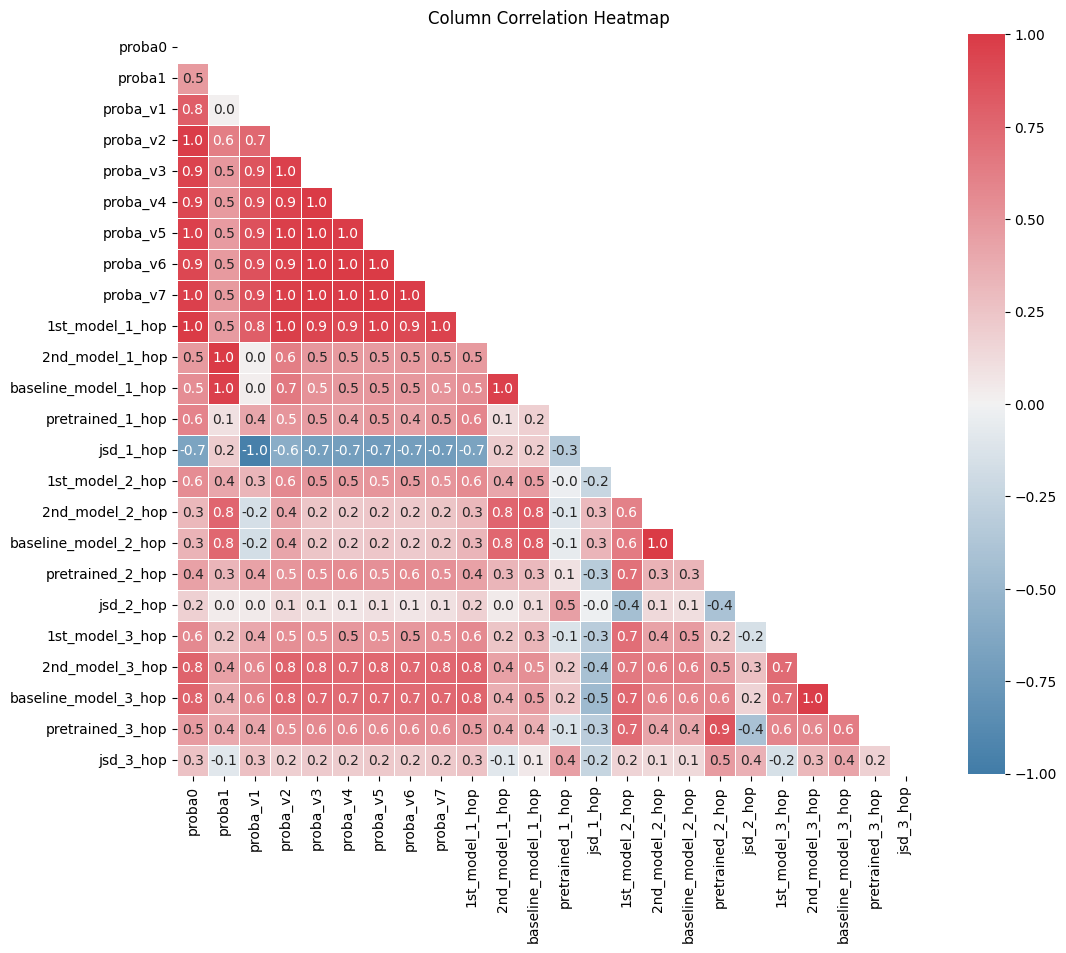

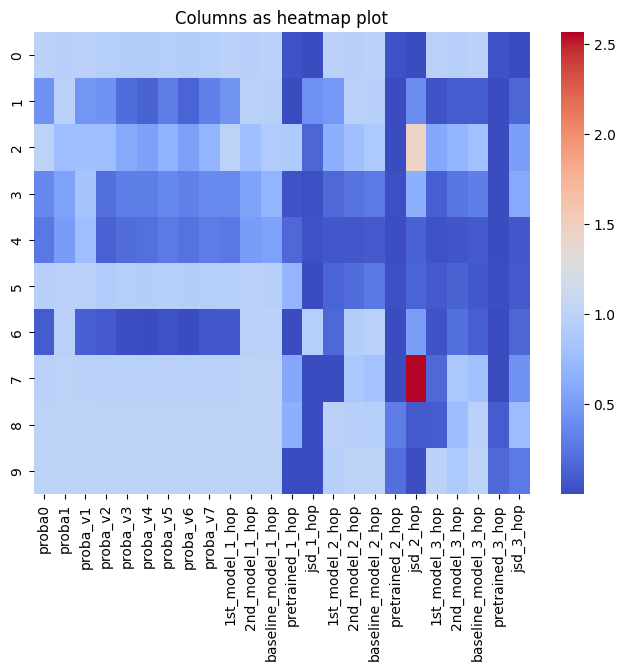

,proba0,proba1,proba_v1,proba_v2,proba_v3,proba_v4,proba_v5,proba_v6,proba_v7,1st_model_1_hop,2nd_model_1_hop,baseline_model_1_hop,pretrained_1_hop,jsd_1_hop,1st_model_2_hop,2nd_model_2_hop,baseline_model_2_hop,pretrained_2_hop,jsd_2_hop,1st_model_3_hop,2nd_model_3_hop,baseline_model_3_hop,pretrained_3_hop,jsd_3_hop
proba0,1.00,0.48,0.80,0.98,0.95,0.92,0.96,0.92,0.96,1.00,0.48,0.54,0.59,-0.66,0.55,0.32,0.34,0.44,0.18,0.57,0.77,0.77,0.47,0.26
proba1,0.48,1.00,0.01,0.63,0.50,0.48,0.47,0.48,0.48,0.47,1.00,0.97,0.10,0.21,0.41,0.76,0.75,0.34,0.03,0.24,0.44,0.36,0.39,-0.09
proba_v1,0.80,0.01,1.00,0.75,0.86,0.87,0.87,0.87,0.87,0.80,0.01,0.02,0.41,-0.96,0.33,-0.16,-0.17,0.43,0.04,0.40,0.57,0.60,0.43,0.27
proba_v2,0.98,0.63,0.75,1.00,0.97,0.95,0.97,0.95,0.97,0.98,0.63,0.65,0.50,-0.58,0.57,0.41,0.42,0.50,0.14,0.54,0.77,0.75,0.54,0.20
proba_v3,0.95,0.50,0.86,0.97,1.00,1.00,1.00,1.00,1.00,0.94,0.50,0.52,0.46,-0.70,0.50,0.25,0.25,0.54,0.08,0.51,0.76,0.74,0.57,0.21
proba_v4,0.92,0.48,0.87,0.95,1.00,1.00,0.99,1.00,0.99,0.92,0.48,0.49,0.44,-0.70,0.48,0.22,0.21,0.56,0.07,0.50,0.75,0.73,0.58,0.21
proba_v5,0.96,0.47,0.87,0.97,1.00,0.99,1.00,0.99,1.00,0.96,0.47,0.50,0.48,-0.73,0.50,0.24,0.24,0.53,0.10,0.52,0.76,0.75,0.55,0.22
proba_v6,0.92,0.48,0.87,0.95,1.00,1.00,0.99,1.00,0.99,0.92,0.48,0.49,0.44,-0.71,0.48,0.22,0.21,0.56,0.06,0.49,0.75,0.73,0.58,0.21
proba_v7,0.96,0.48,0.87,0.97,1.00,0.99,1.00,0.99,1.00,0.96,0.48,0.50,0.48,-0.72,0.51,0.25,0.24,0.53,0.10,0.52,0.76,0.75,0.55,0.22
1st_model_1_hop,1.00,0.47,0.80,0.98,0.94,0.92,0.96,0.92,0.96,1.00,0.48,0.54,0.59,-0.67,0.56,0.32,0.34,0.44,0.18,0.57,0.77,0.77,0.47,0.26


In [64]:
# view_df[['proba0', 'proba1', 'proba_v1', 'proba_v2', 'proba_v3', "proba_v4", "proba_v5", "proba_v6", "proba_v7", '1st_model_1_hop',
#        '2nd_model_1_hop', 'baseline_model_1_hop', 'pretrained_1_hop',
#        'jsd_1_hop', '1st_model_2_hop', '2nd_model_2_hop',
#        'baseline_model_2_hop', 'pretrained_2_hop', 'jsd_2_hop',
#        '1st_model_3_hop', '2nd_model_3_hop', 'baseline_model_3_hop',
#        'pretrained_3_hop', 'jsd_3_hop']].corr()

plot_correlation_heatmap(view_df[['proba0', 'proba1', 'proba_v1', 'proba_v2', 'proba_v3', "proba_v4", "proba_v5", "proba_v6", "proba_v7", '1st_model_1_hop',
       '2nd_model_1_hop', 'baseline_model_1_hop', 'pretrained_1_hop',
       'jsd_1_hop', '1st_model_2_hop', '2nd_model_2_hop',
       'baseline_model_2_hop', 'pretrained_2_hop', 'jsd_2_hop',
       '1st_model_3_hop', '2nd_model_3_hop', 'baseline_model_3_hop',
       'pretrained_3_hop', 'jsd_3_hop']], figsize=(12, 12), fmt='.1f',)

In [49]:
ndf

,proba0,proba1,labels,label_ids,1st_model_3_hop,2nd_model_3_hop,baseline_model_3_hop,pretrained_3_hop,kl_divs_[1_2]_3_hop,kl_divs_[2_1]_3_hop,jsd_3_hop
0,0.98,0.96,Amanda,21542,0.99,0.96,0.99,0.04,0.02,0.01,0.00
1,0.43,0.98,baked,13635,0.05,0.10,0.10,0.00,0.44,0.64,0.15
2,1.00,0.77,cookies,5081,0.59,0.69,0.78,0.01,1.26,1.63,0.52
3,0.37,0.54,and,11,0.10,0.25,0.31,0.00,0.35,2.42,0.59
4,0.26,0.50,will,56,0.04,0.06,0.09,0.01,0.27,0.25,0.07
5,0.95,0.96,bring,830,0.08,0.14,0.07,0.01,0.16,0.38,0.09
6,0.09,0.97,Jerry,16637,0.04,0.20,0.11,0.01,0.42,0.64,0.16
7,0.98,0.99,some,128,0.16,0.87,0.80,0.01,1.38,1.65,0.44
8,1.00,1.00,tomorrow,5721,0.10,0.76,0.97,0.10,2.77,1.67,0.75
9,1.00,1.00,.,5,0.99,0.88,1.00,0.17,1.16,0.11,0.28


In [50]:
one_hop

,proba0,proba1,labels,1st_model_1_hop,2nd_model_1_hop,baseline_model_1_hop,pretrained_1_hop,kl_divs_[1_2]_1_hop,kl_divs_[2_1]_1_hop,jsd_1_hop
0,0.98,0.96,Amanda,0.99,0.96,0.99,0.04,0.02,0.01,0.00
1,0.43,0.98,baked,0.45,0.98,0.95,0.00,0.71,1.80,0.42
2,1.00,0.77,cookies,1.00,0.78,0.91,0.90,0.69,0.23,0.16
3,0.37,0.54,and,0.37,0.54,0.68,0.05,0.07,0.09,0.02
4,0.26,0.50,will,0.26,0.50,0.53,0.16,0.16,0.15,0.04
5,0.95,0.96,bring,0.95,0.97,0.96,0.69,0.01,0.01,0.00
6,0.09,0.97,Jerry,0.08,0.97,0.99,0.00,2.36,3.42,0.95
7,0.98,0.99,some,0.98,0.99,1.00,0.58,0.01,0.02,0.00
8,1.00,1.00,tomorrow,1.00,1.00,1.00,0.64,0.00,0.00,0.00
9,1.00,1.00,.,1.00,1.00,1.00,0.00,0.00,0.00,0.00


In [51]:
two_hop

,proba0,proba1,labels,1st_model_2_hop,2nd_model_2_hop,baseline_model_2_hop,pretrained_2_hop,kl_divs_[1_2]_2_hop,kl_divs_[2_1]_2_hop,jsd_2_hop
0,0.98,0.96,Amanda,0.99,0.96,0.99,0.04,0.02,0.01,0.00
1,0.43,0.98,baked,0.47,0.98,0.95,0.00,0.67,1.69,0.39
2,1.00,0.77,cookies,0.64,0.78,0.88,0.01,1.04,5.52,1.44
3,0.37,0.54,and,0.16,0.23,0.27,0.02,2.54,0.39,0.63
4,0.26,0.50,will,0.07,0.06,0.08,0.01,0.21,0.52,0.13
5,0.95,0.96,bring,0.15,0.19,0.27,0.03,0.13,0.59,0.14
6,0.09,0.97,Jerry,0.17,0.93,0.96,0.01,1.45,1.95,0.50
7,0.98,0.99,some,0.00,0.86,0.80,0.00,9.86,2.61,2.57
8,1.00,1.00,tomorrow,0.99,0.95,0.95,0.30,0.36,0.05,0.09
9,1.00,1.00,.,0.96,0.99,1.00,0.21,0.03,0.07,0.02


In [52]:
model_1_proba["logits"][0]

tensor([1.2927e-13, 2.1346e-06, 5.7964e-08,  ..., 6.0095e-21, 4.8673e-21,
        5.5670e-21], dtype=torch.float64)

In [54]:
x = torch.tensor([1e-6] * 10000 + [1.0])
calculate_jsd(x, x)

0.0

In [55]:
x = torch.tensor([1e-6] * 10000 + [1.0])
y = torch.tensor([1.0] + [1e-6] * 10000)
calculate_jsd(x, y)

6.214615345001221

In [107]:
from collections import Counter
c = Counter(torch.tensor([1.0, 2.0, 3.0, 1.0]).tolist())
c.keys()
c.values()
c

dict_keys([1.0, 2.0, 3.0])

dict_values([2, 1, 1])

Counter({1.0: 2, 2.0: 1, 3.0: 1})

In [104]:
for i in torch.tensor([1.0, 2.0, 3.0]):
    i

tensor(1.)

tensor(2.)

tensor(3.)

In [105]:
c[torch.tensor(1.0)]

0